In [ ]:
jupyter nbconvert --clear-output --inplace Term_Deposit.ipynb

# Summary

**Objective:** Predict which customers will subscribe to a term deposit, then uncover sub-segments among those subscribers for targeted follow-up.

**Key Metric:** 5-fold CV accuracy ≥ 81% on the positive class (we’ll also monitor precision & recall for “yes”).

**High-Level Findings:**
1. **Call duration** and **customer balance** are the strongest predictors of subscription.
2. **Students**, **retirees**, and **management** roles convert at the highest rates.
3. Within subscribers, **4 distinct clusters** each with unique age, balance, and seasonal patterns.

**Business Impact:**
- Prioritize long calls (> 200 s) with high-balance customers in peak months (May–August).
- Tailor marketing scripts and follow-up offers per cluster (e.g., “retirees, high balance” vs. “students, medium balance”).

# Setup

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random
from pycaret.classification import *

Data source

In [2]:
path = '/TermDeposit/term-deposit-marketing-2020.csv'
data = pd.read_csv(path)
df = pd.DataFrame(data)

# Data definition

In [4]:
# View first rows
df.head()

# Data types & non-null counts
df.info()

# Summary statistics for numeric columns
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


count         mean          std     min    25%    50%     75%  \
age       40000.0    40.544600     9.641776    19.0   33.0   39.0    48.0   
balance   40000.0  1274.277550  2903.769716 -8019.0   54.0  407.0  1319.0   
day       40000.0    16.017225     8.278127     1.0    8.0   17.0    21.0   
duration  40000.0   254.824300   259.366498     0.0  100.0  175.0   313.0   
campaign  40000.0     2.882175     3.239051     1.0    1.0    2.0     3.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0

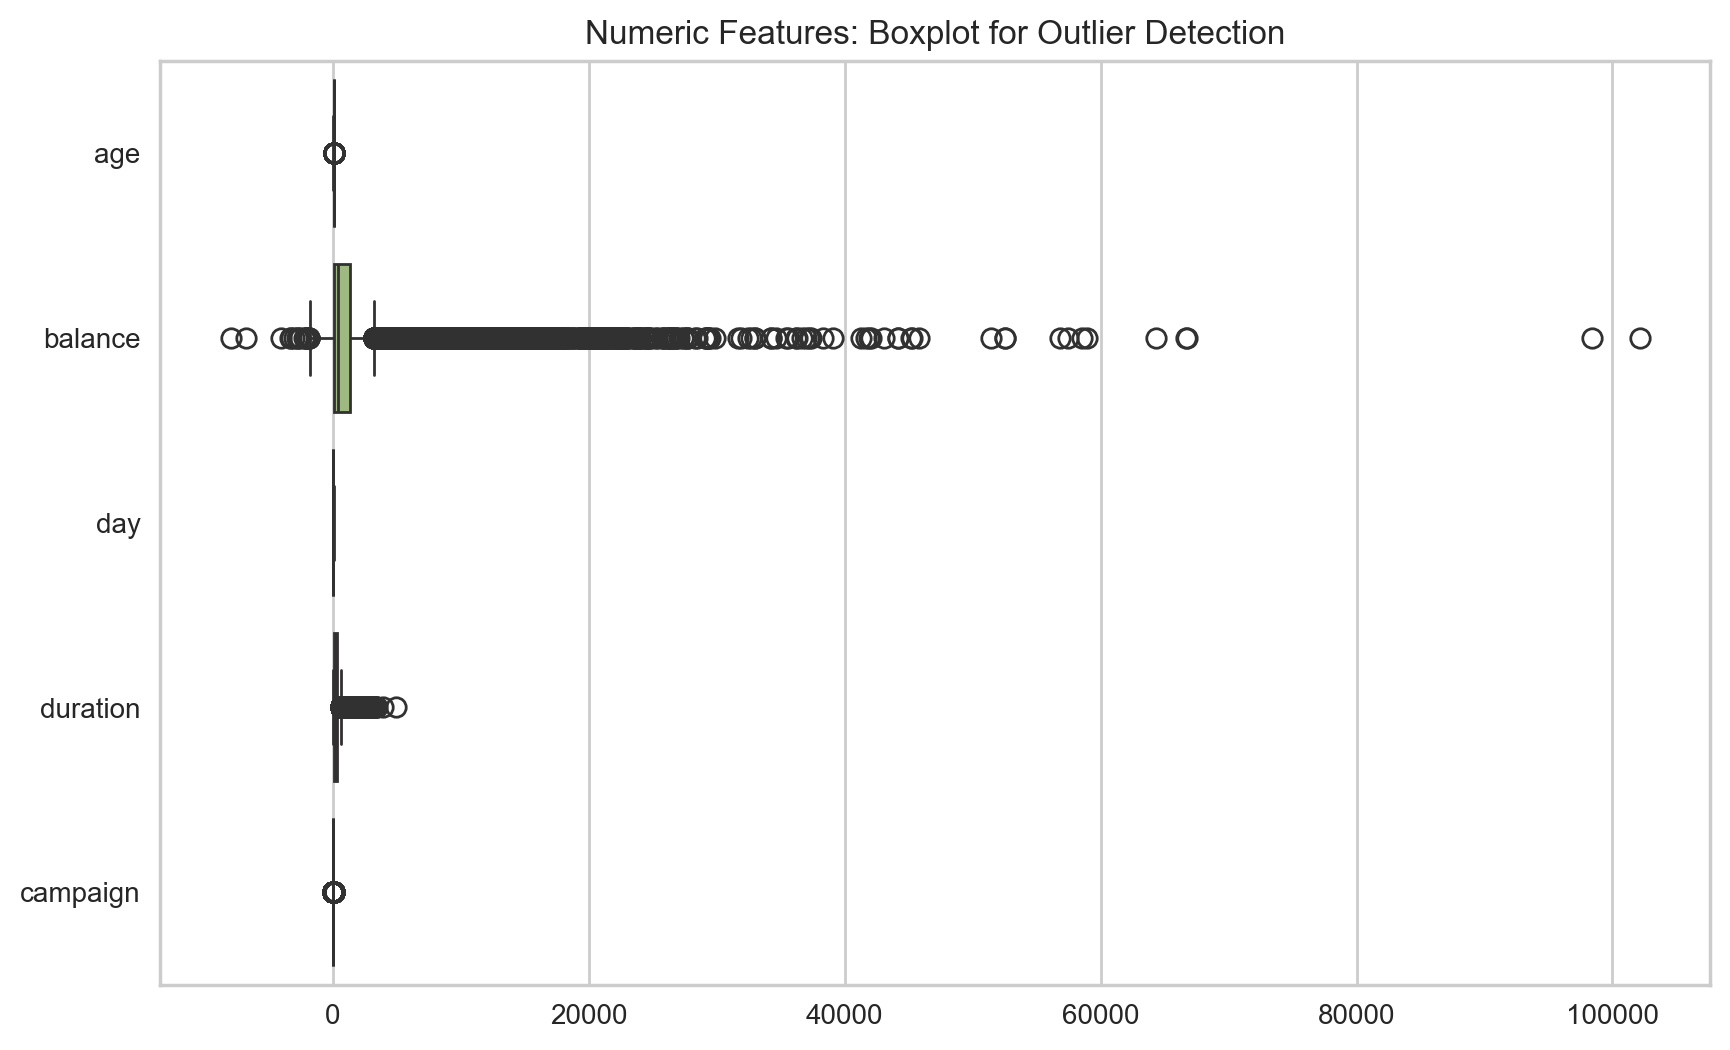

In [16]:
num_cols = ['age','balance','day','duration','campaign']
cat_cols = [col for col in df.columns if col not in num_cols + ['y']]
# Simple boxplot for numeric features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[num_cols], orient='h')
plt.title("Numeric Features: Boxplot for Outlier Detection")
plt.show()

# EDA

**EDA Key Insights**

- **Call Duration**  
  - Subscribers have **much longer conversations** (median 629 s) than non-subscribers (median 164 s). Longer calls strongly correlate with conversion.

- **Account Balance**  
  - Median balance for subscribers is **€620** versus **€395** for non-subscribers. Wealthier customers are more likely to sign up.

- **Engagement (Campaign Attempts)**  
  - Subscribers convert in **fewer calls** (mean ~2.4 attempts) compared to non-subscribers (mean ~2.9). There are diminishing returns after two contacts.

- **Job Segments**  
  - **Highest conversion rates**:  
    - Students 15.6%  
    - Retirees 10.5%  
    - Unemployed 8.7%  
  - **Lowest conversion rates**:  
    - Housemaids 4.9%  
    - Blue-collar 5.7%

- **Age**  
  - Median age is **37** for subscribers vs. **39** for non-subscribers. Age differences are small, suggesting other factors drive conversion.


<Figure size 800x550 with 0 Axes>

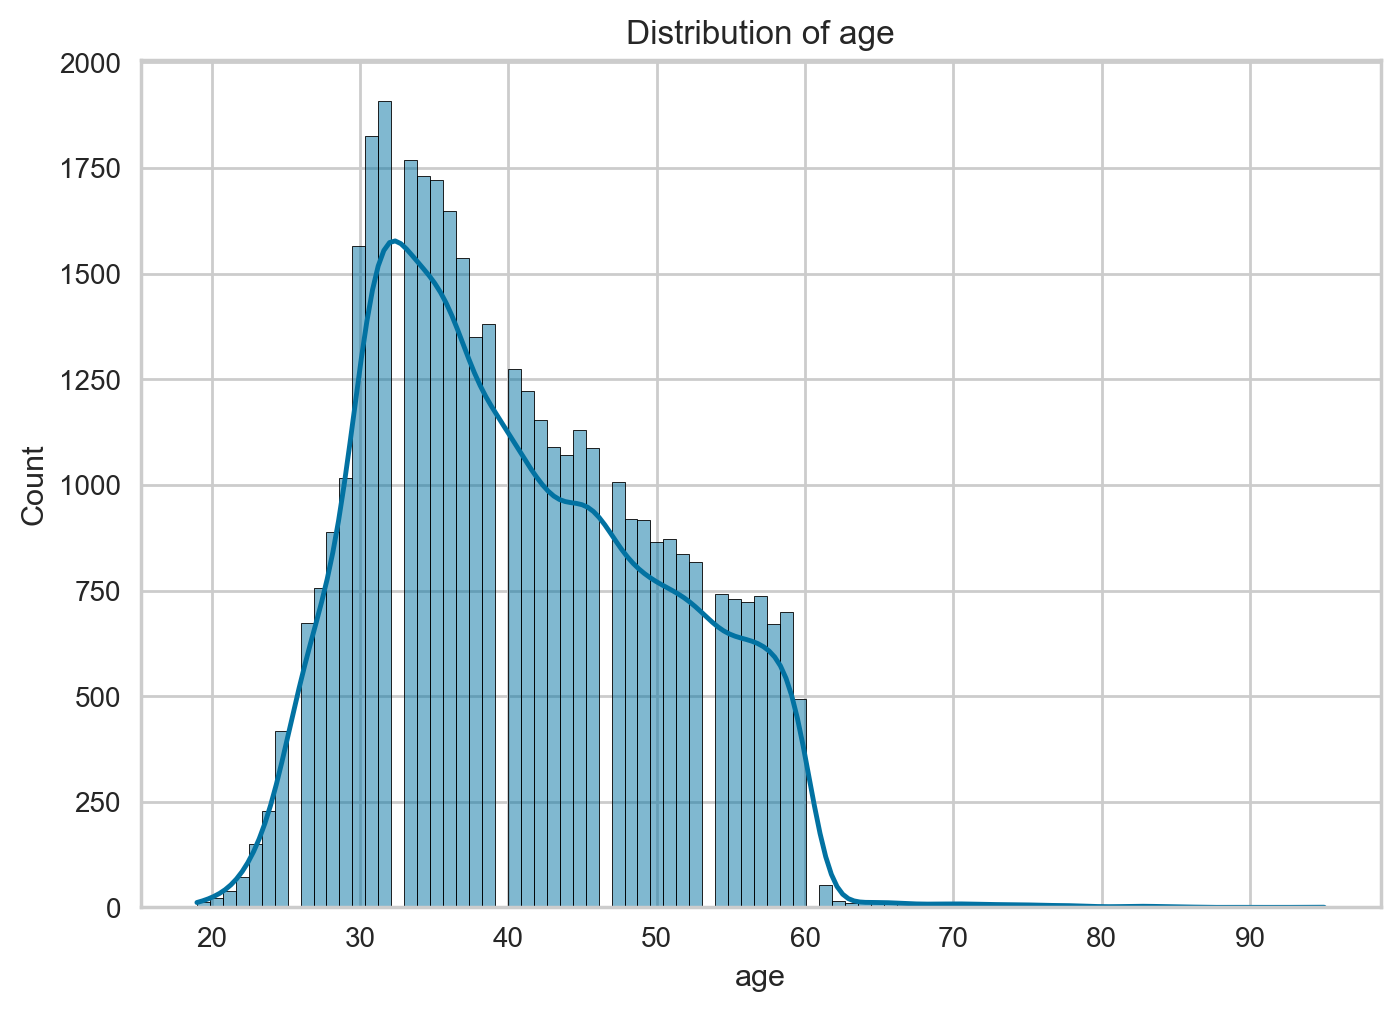

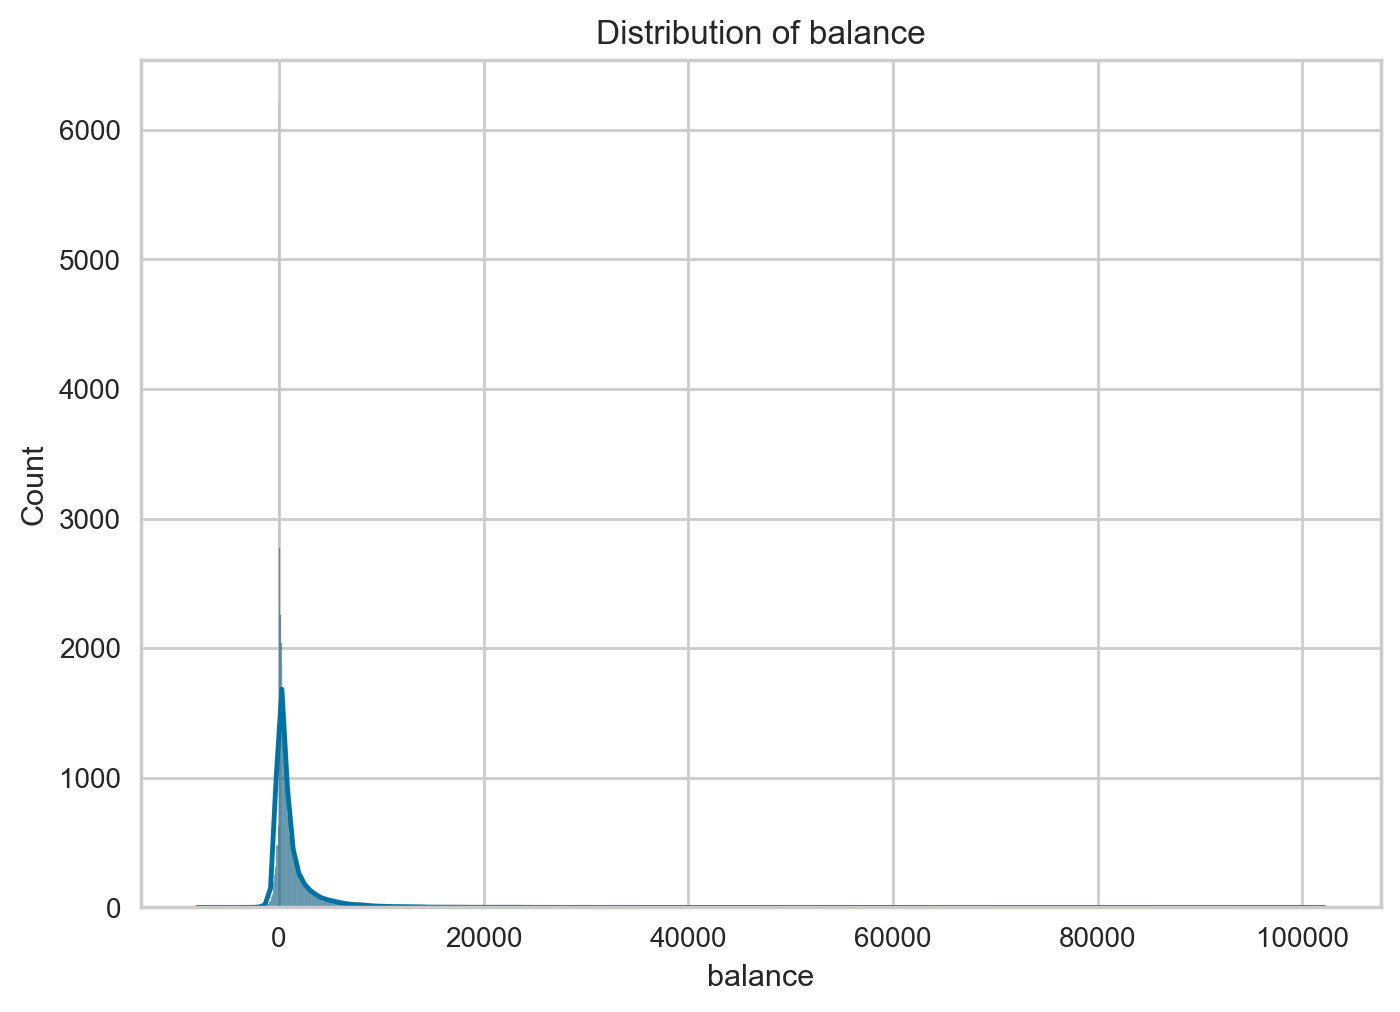

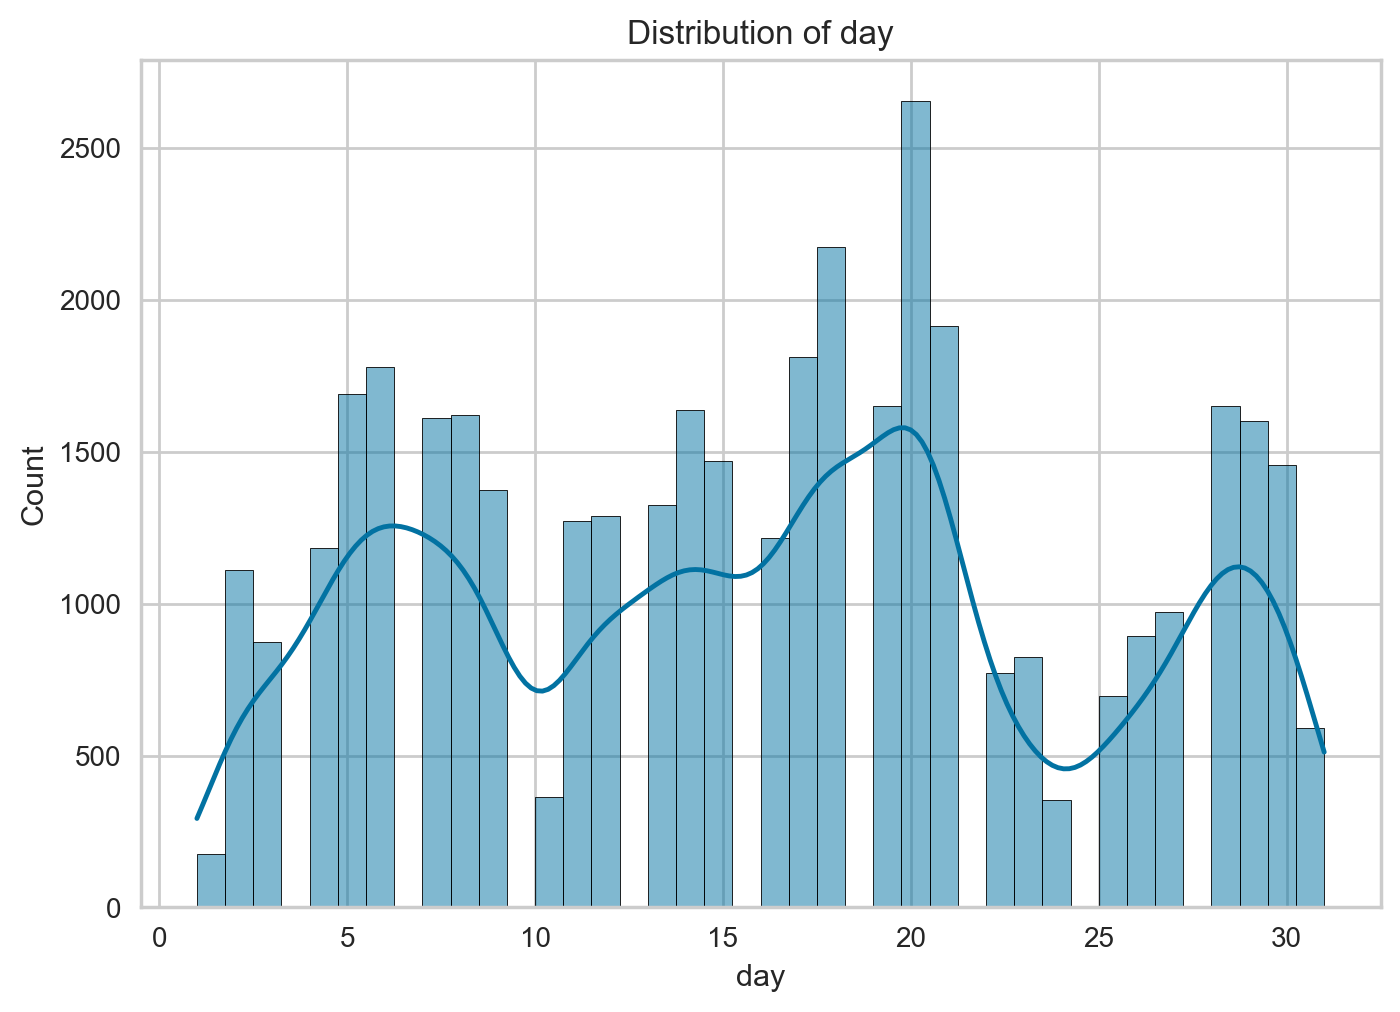

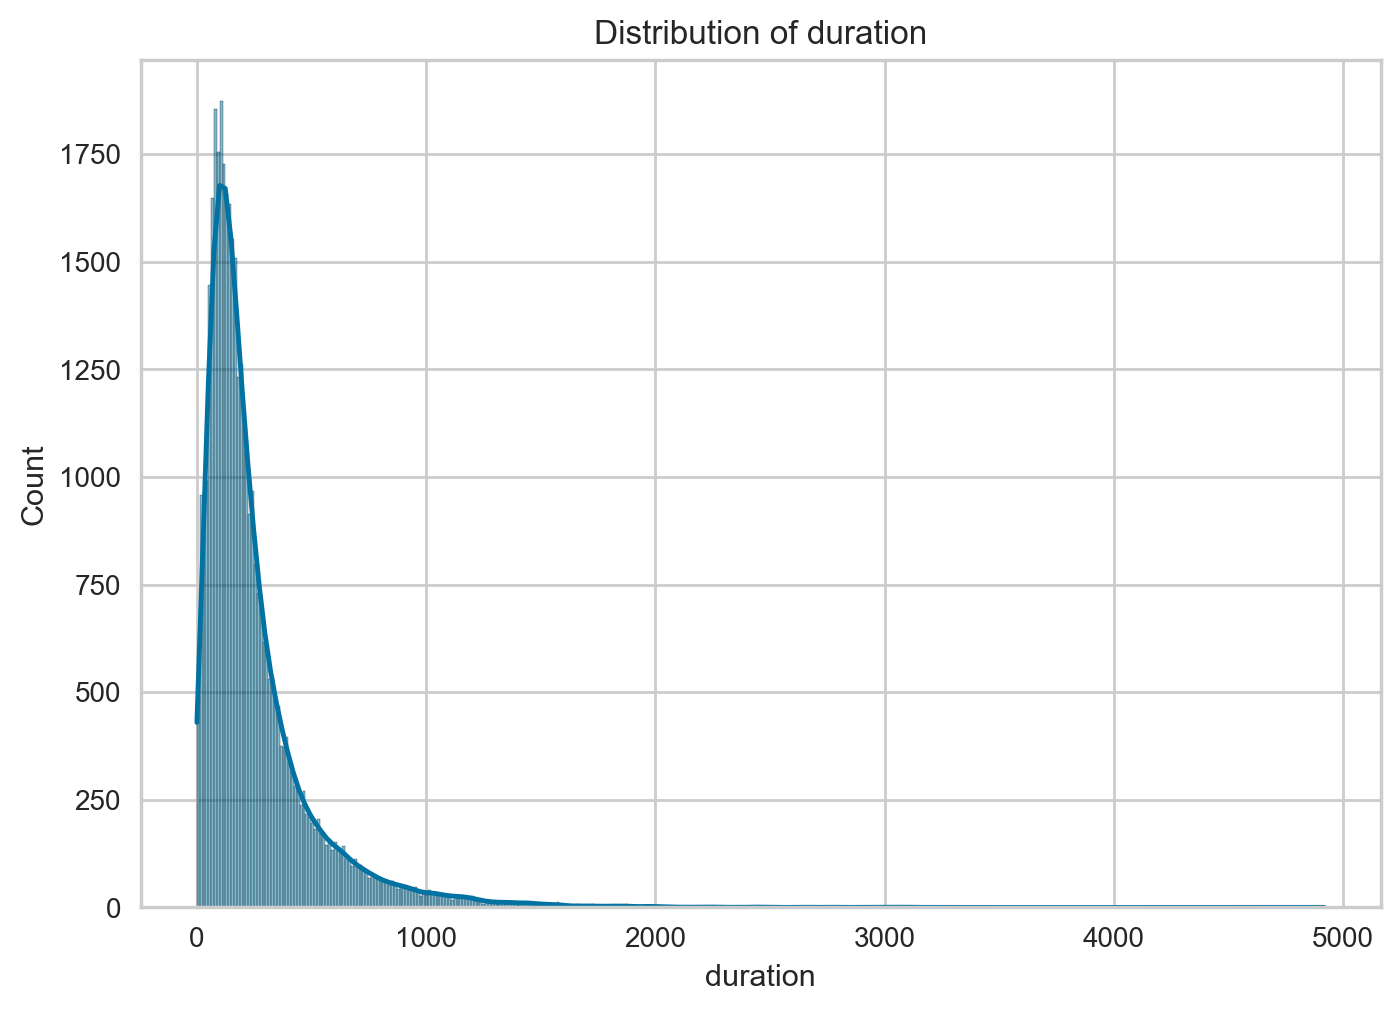

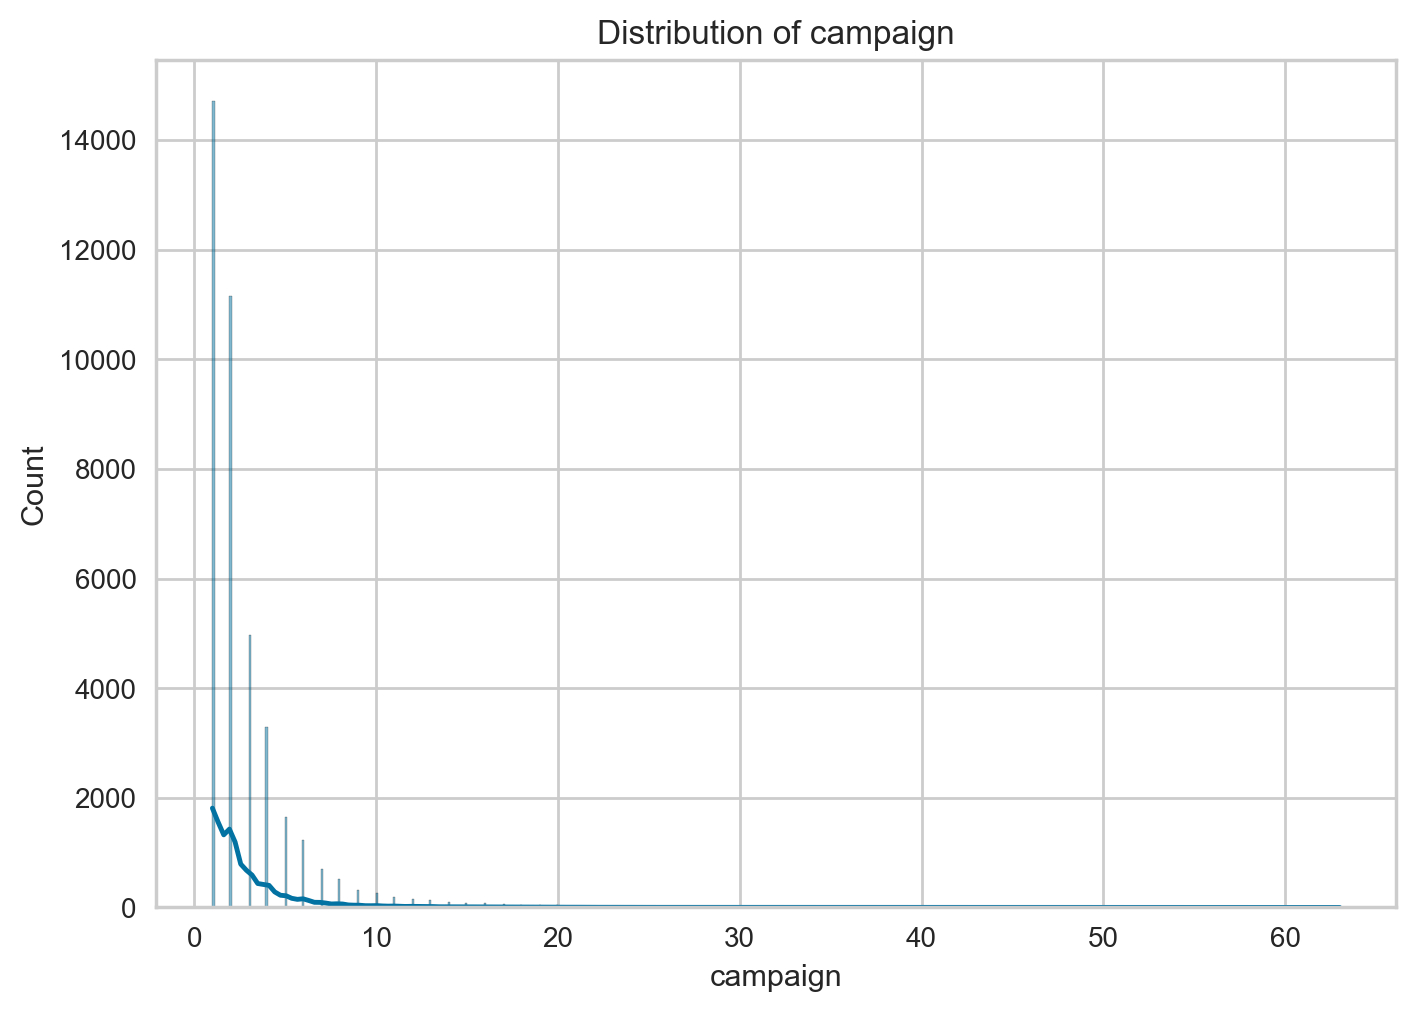

In [99]:
for col in num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

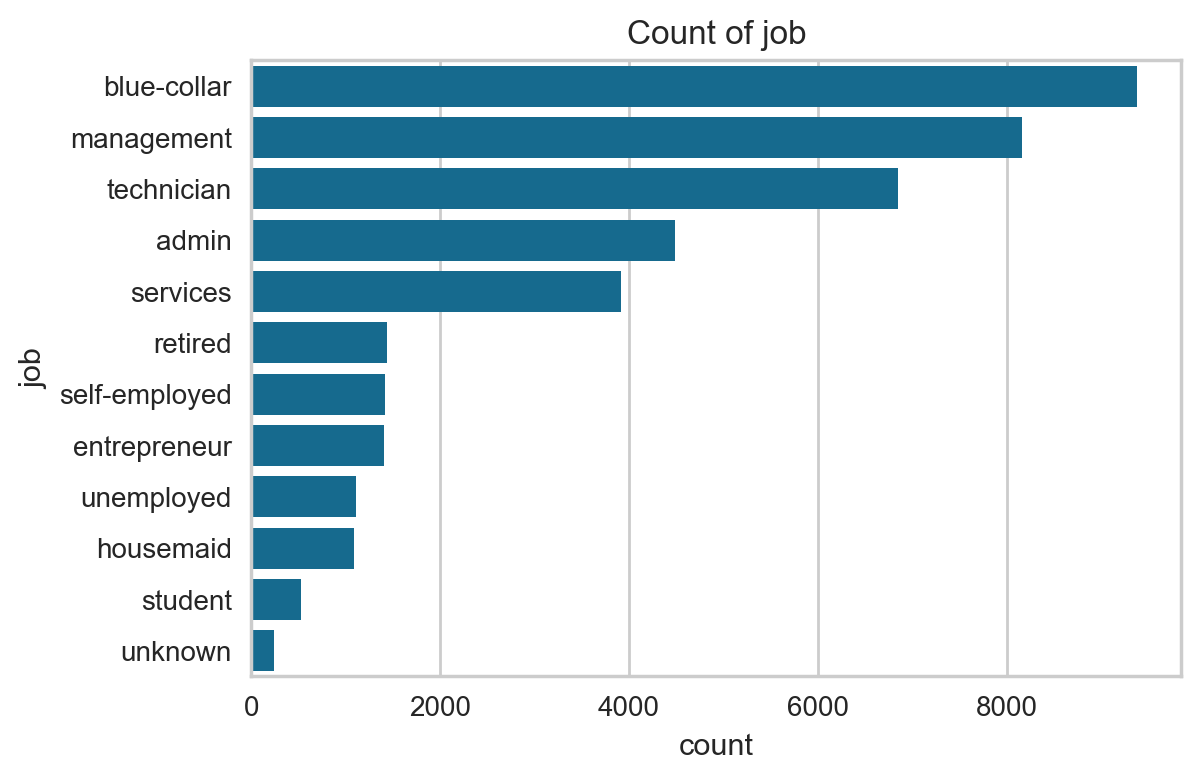

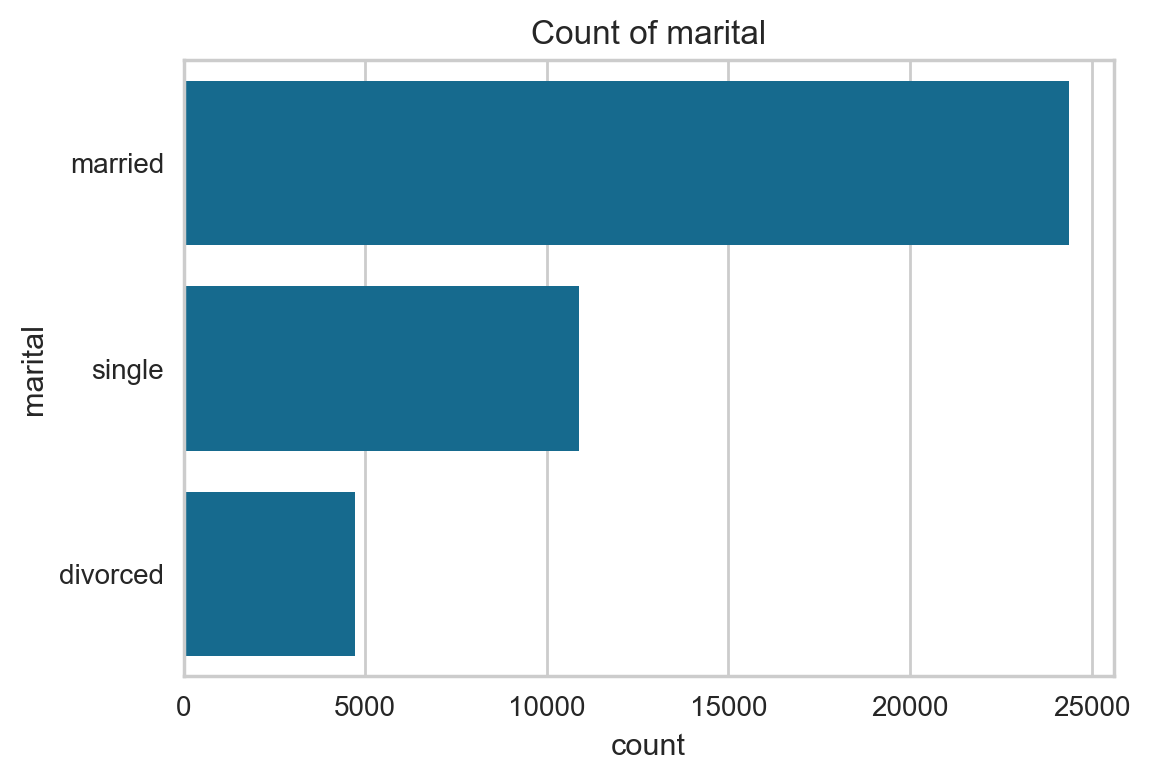

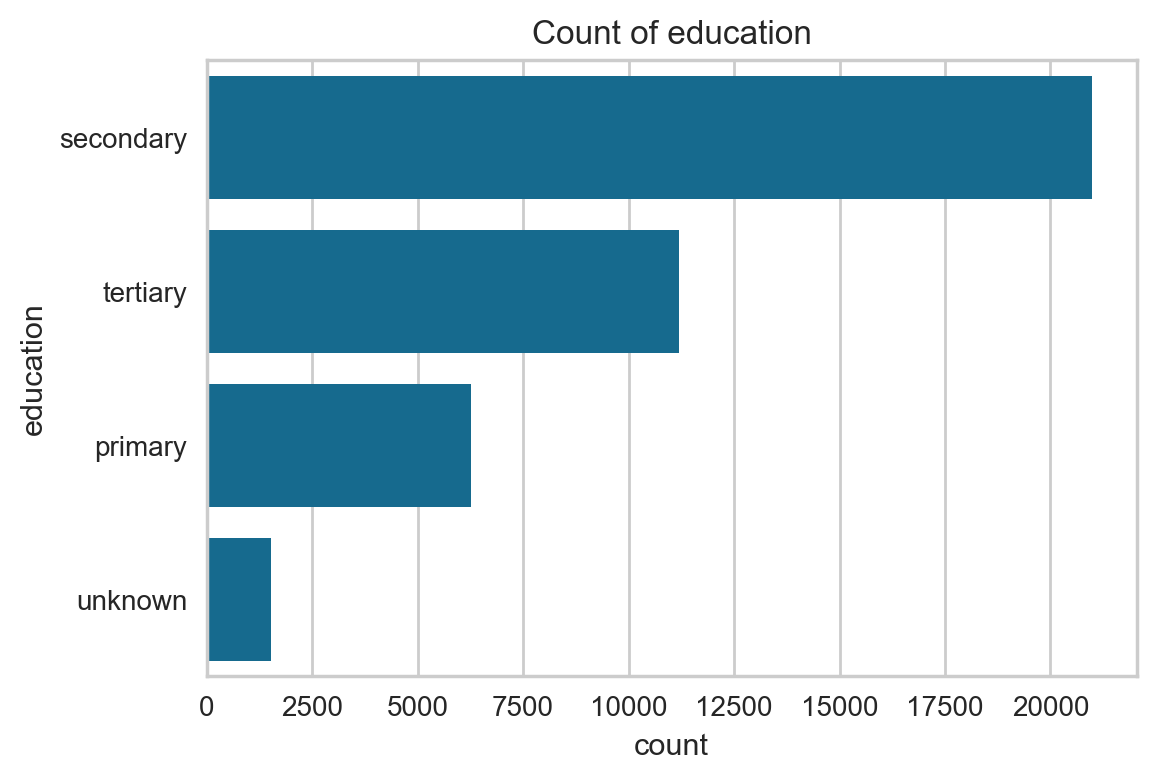

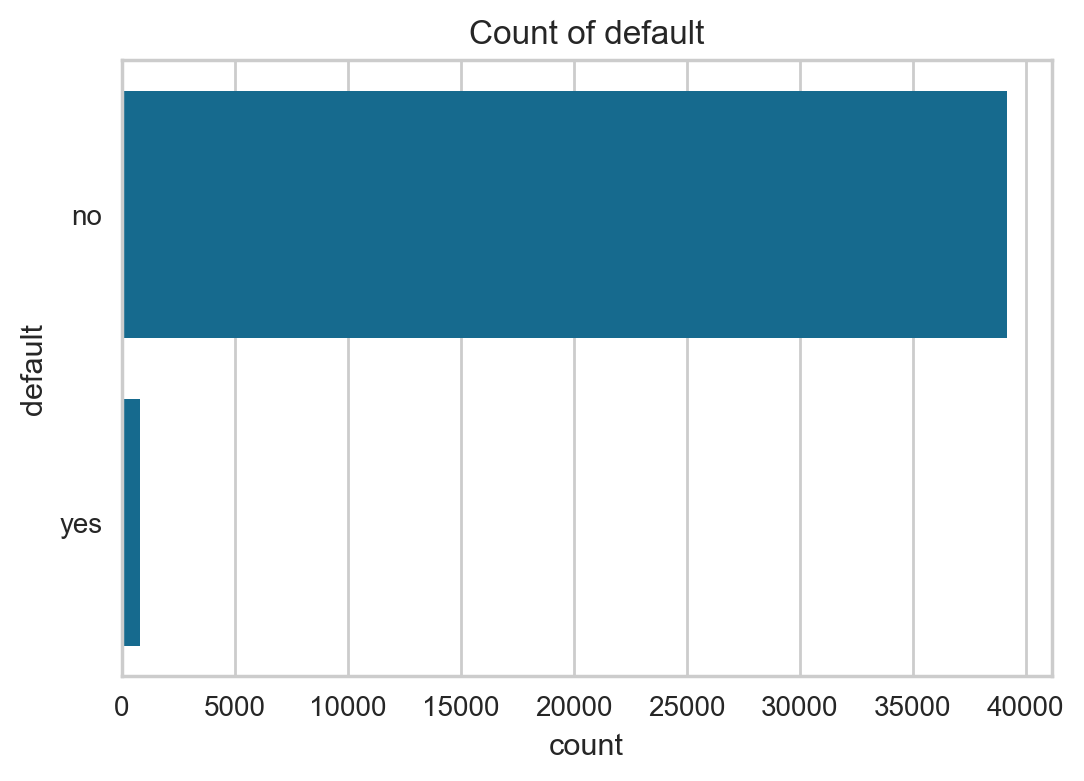

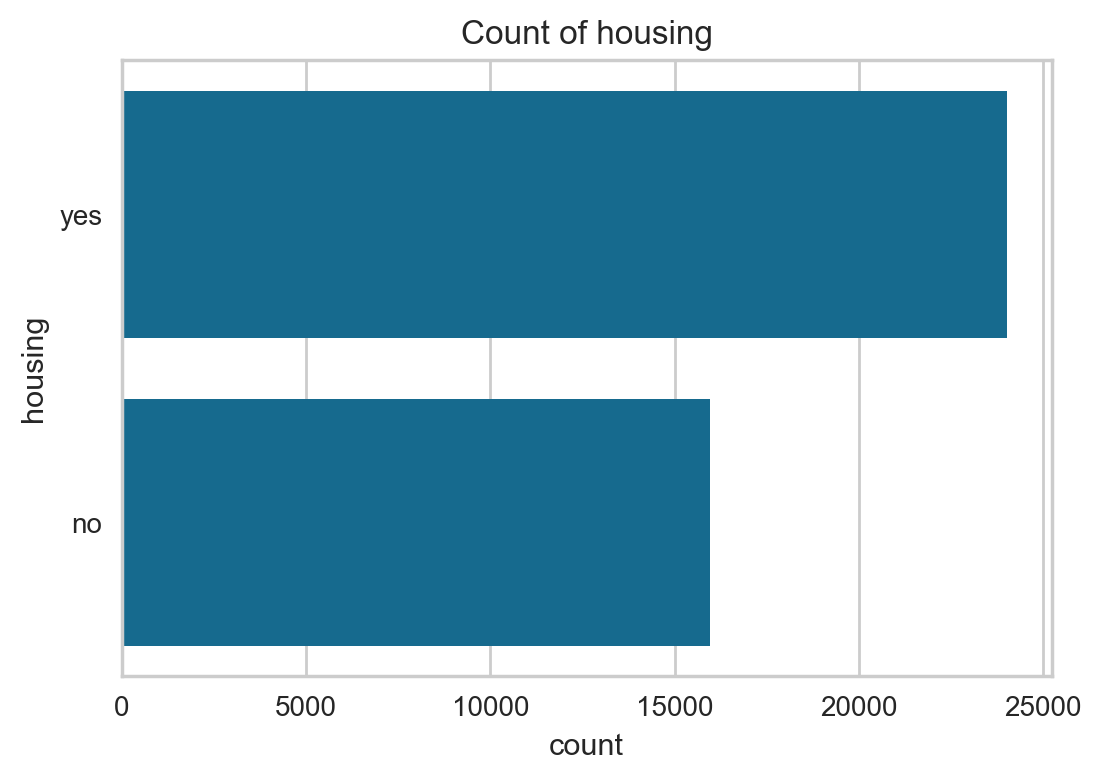

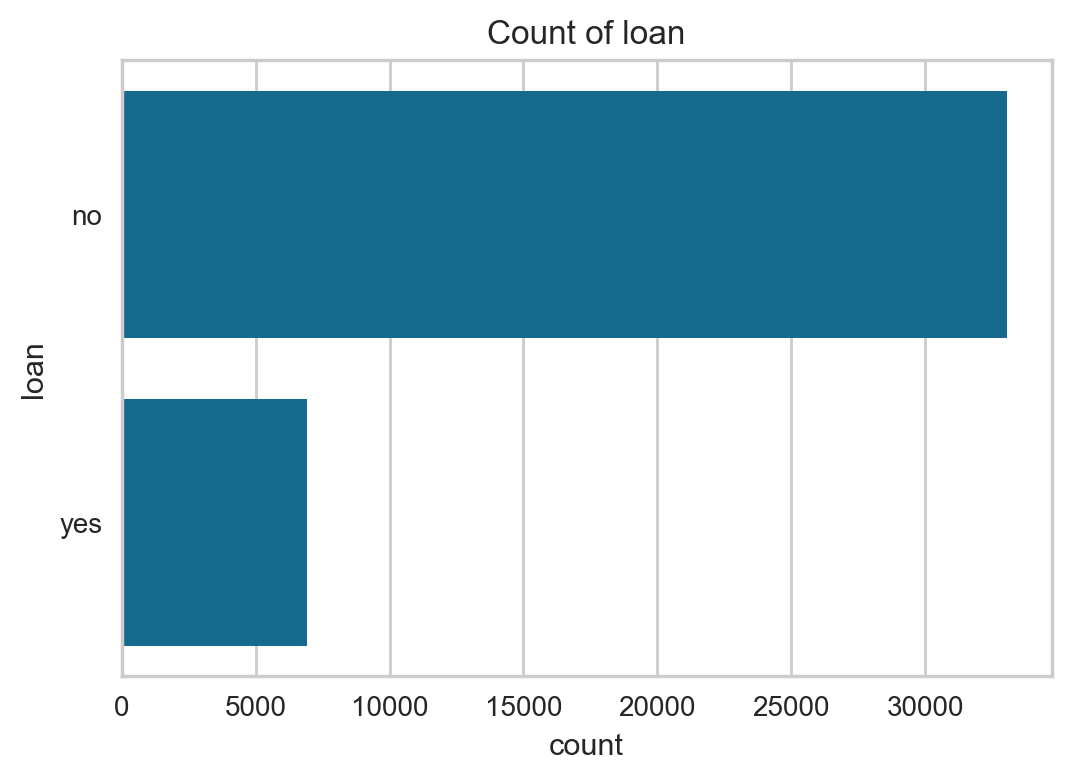

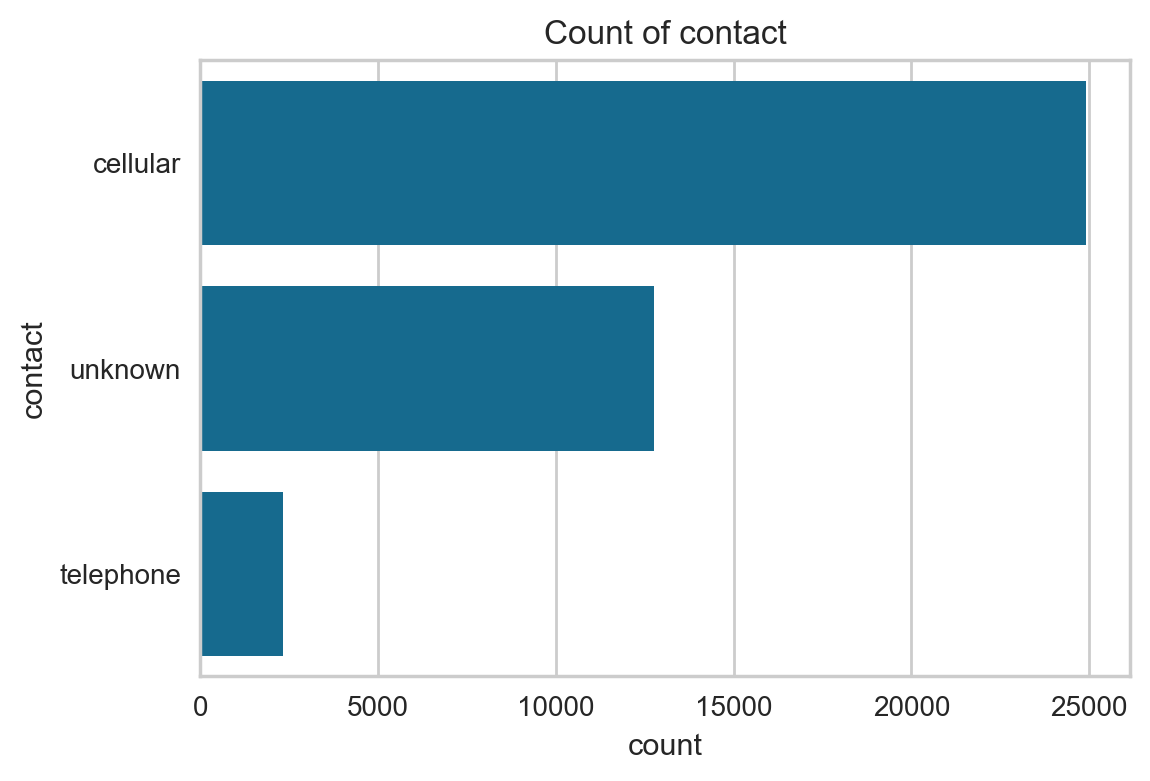

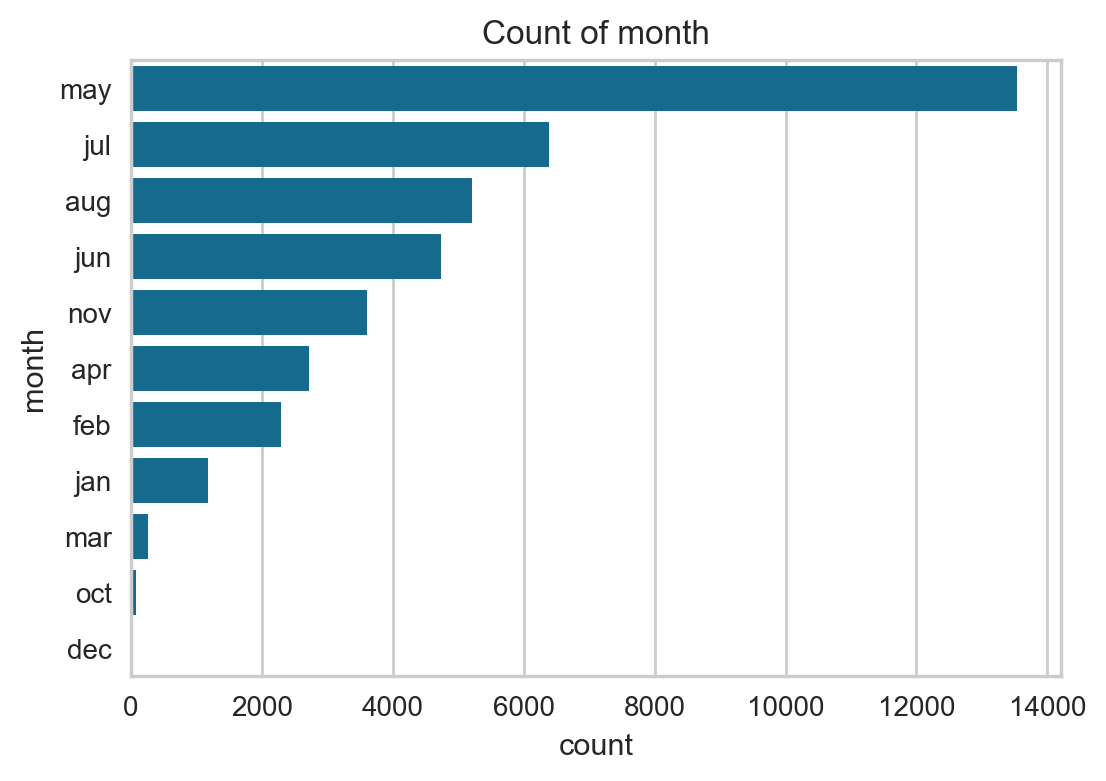

In [100]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.show()

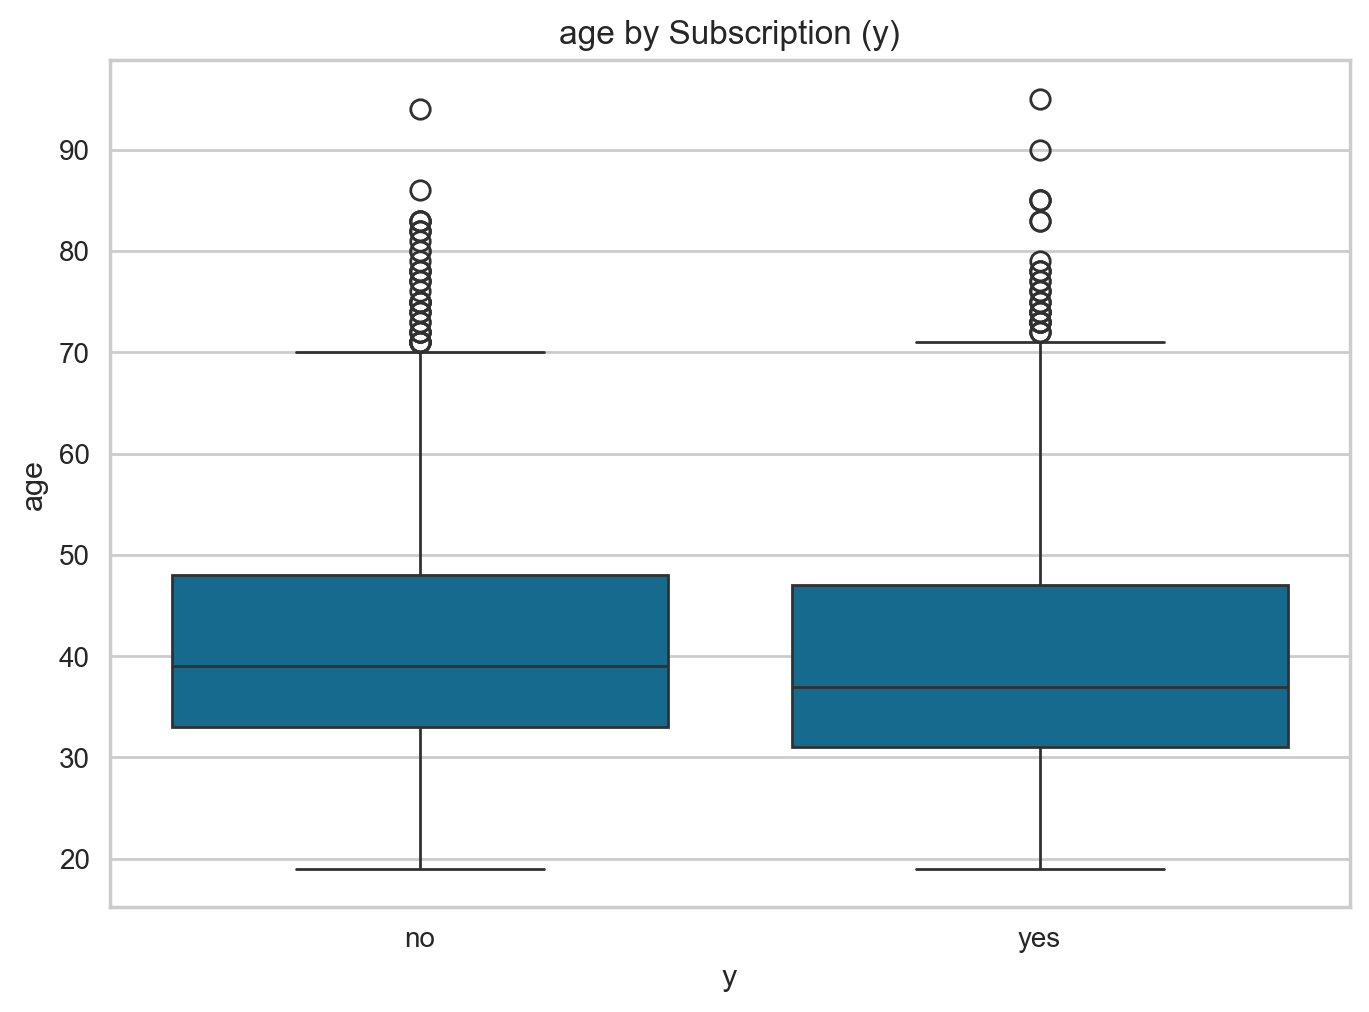

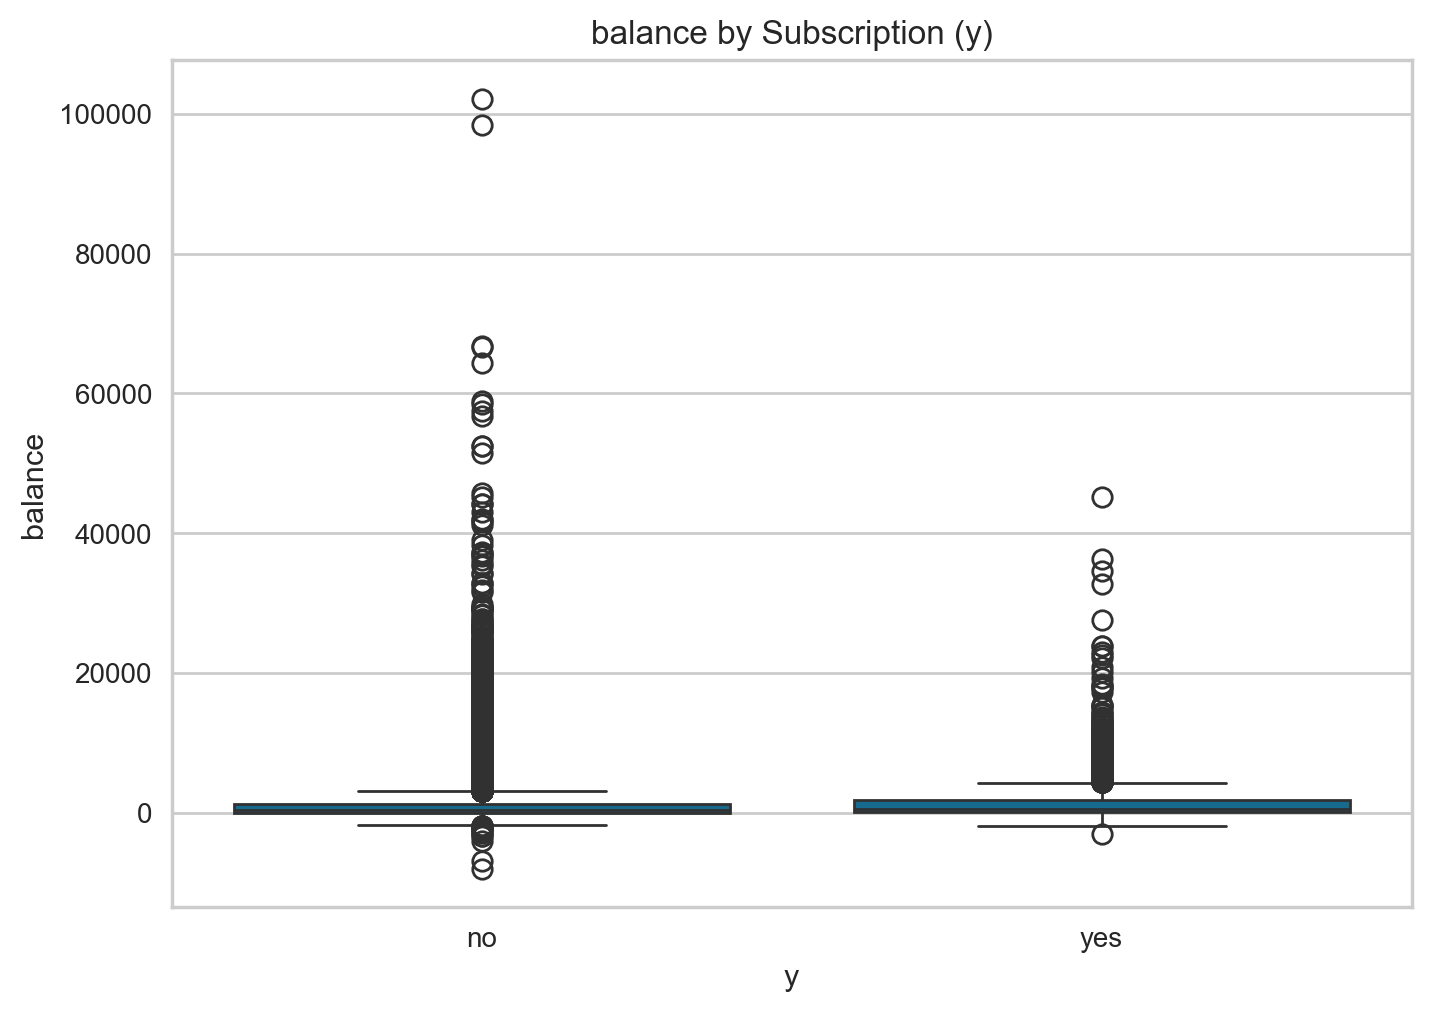

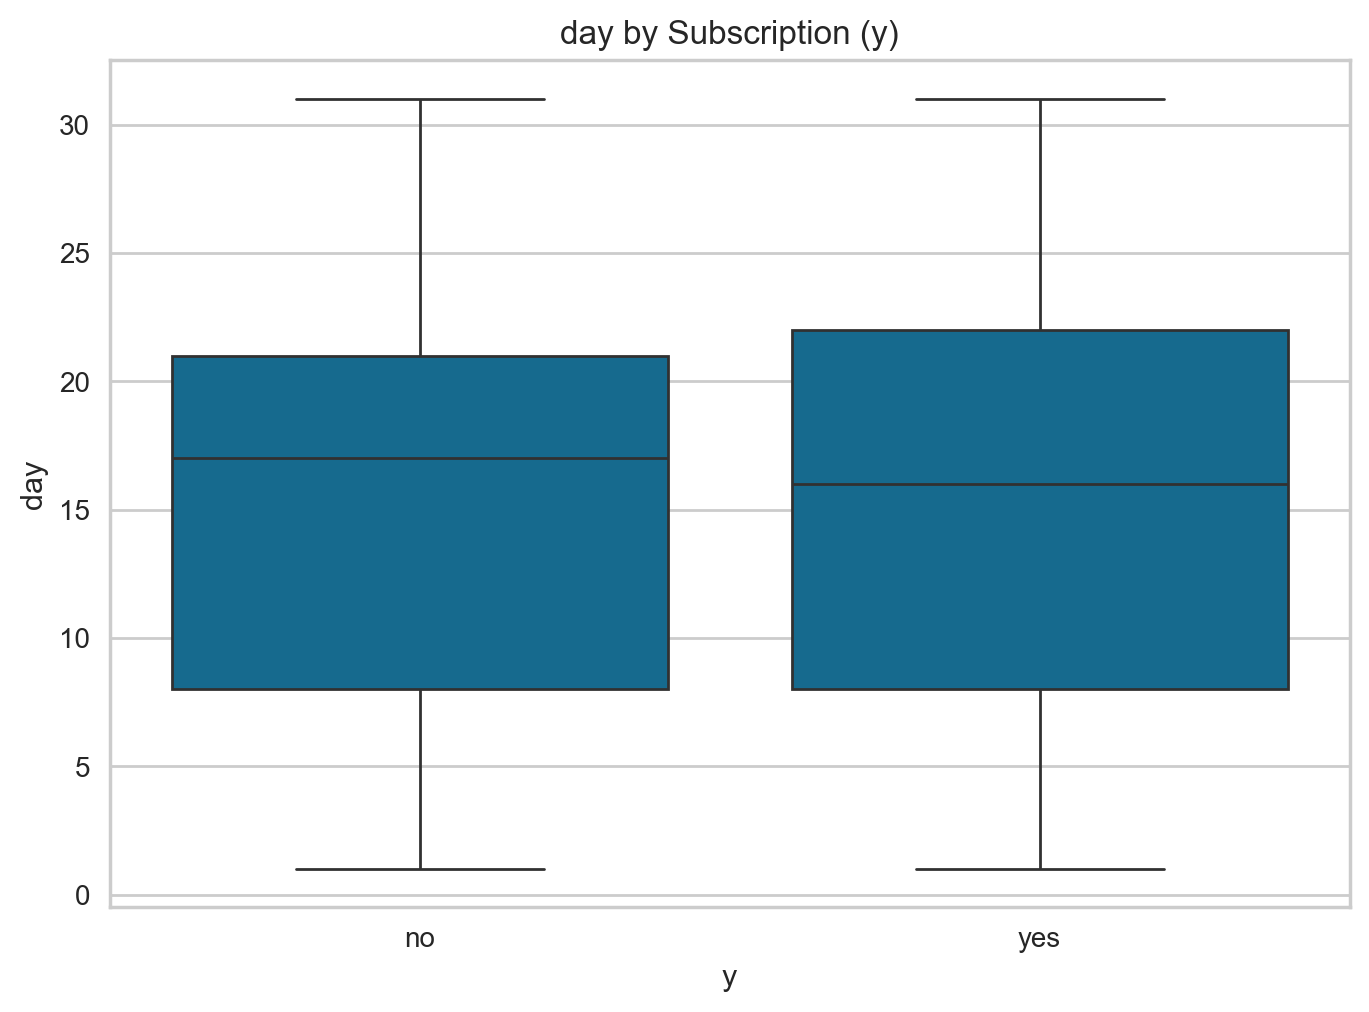

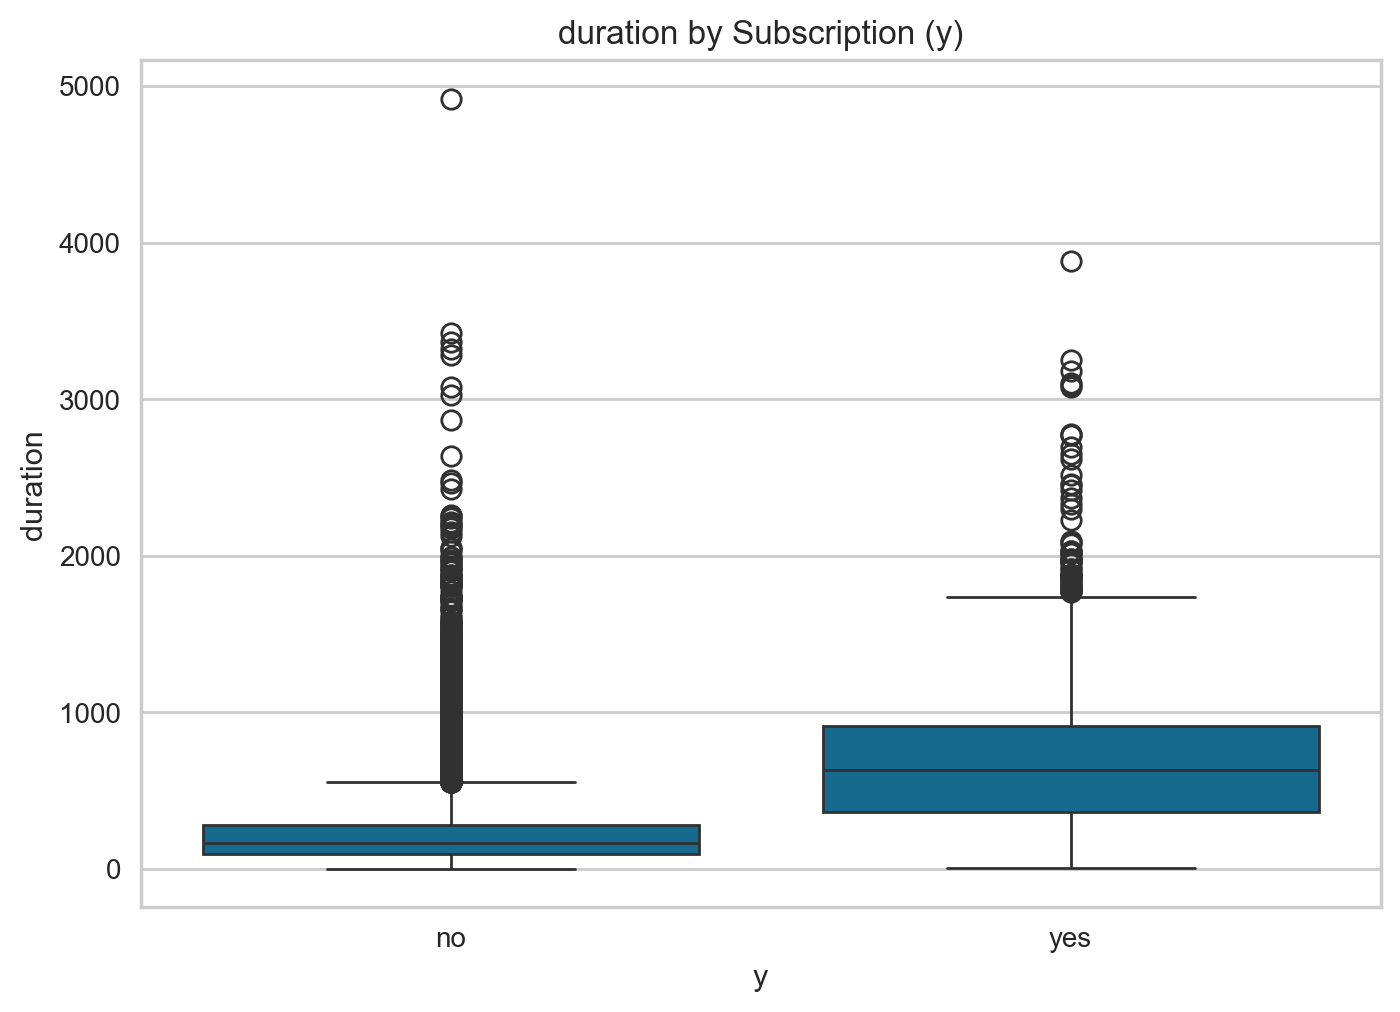

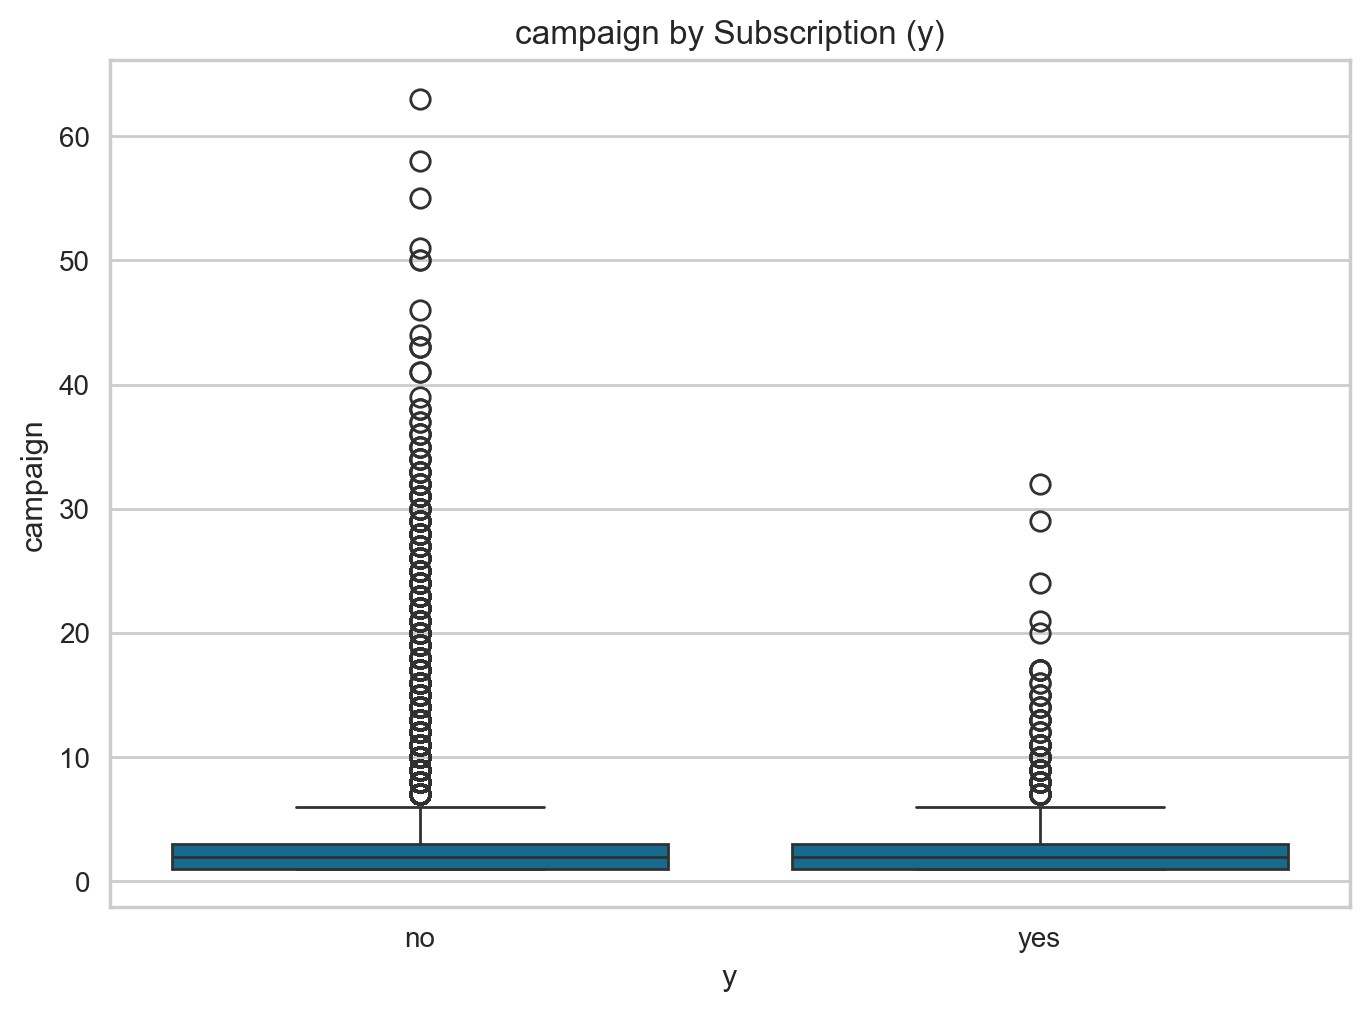

In [101]:
for col in num_cols:
    plt.figure()
    sns.boxplot(x='y', y=col, data=df)
    plt.title(f"{col} by Subscription (y)")
    plt.show()

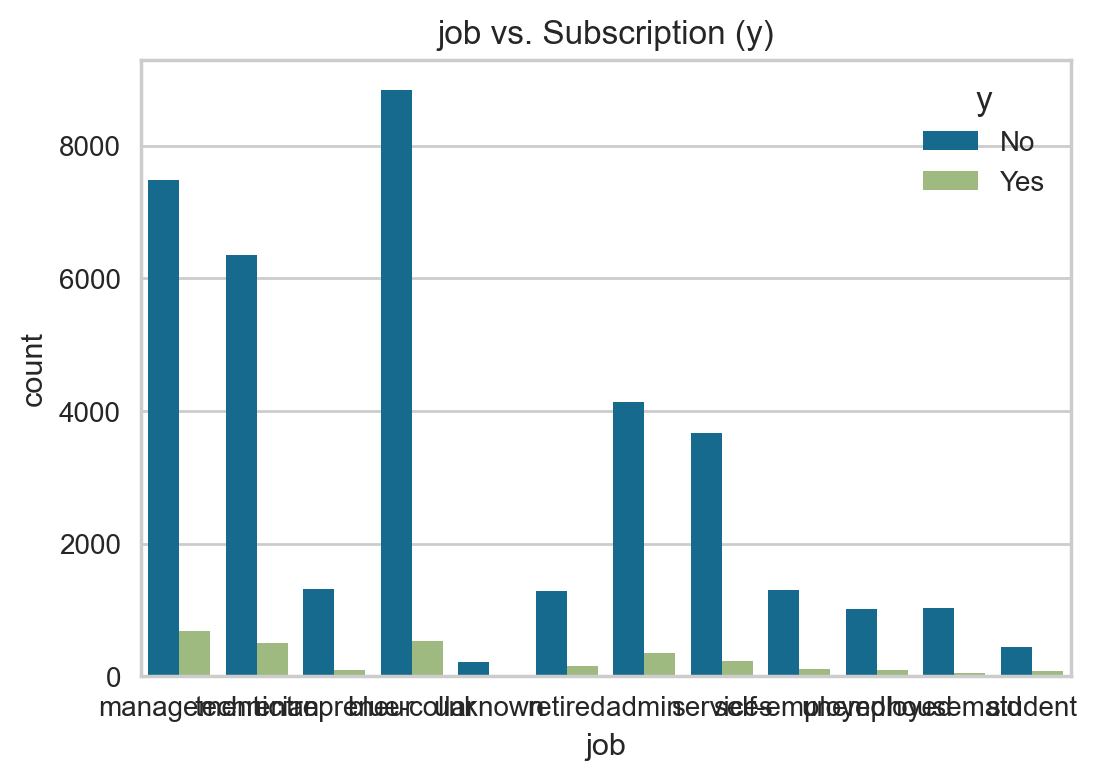

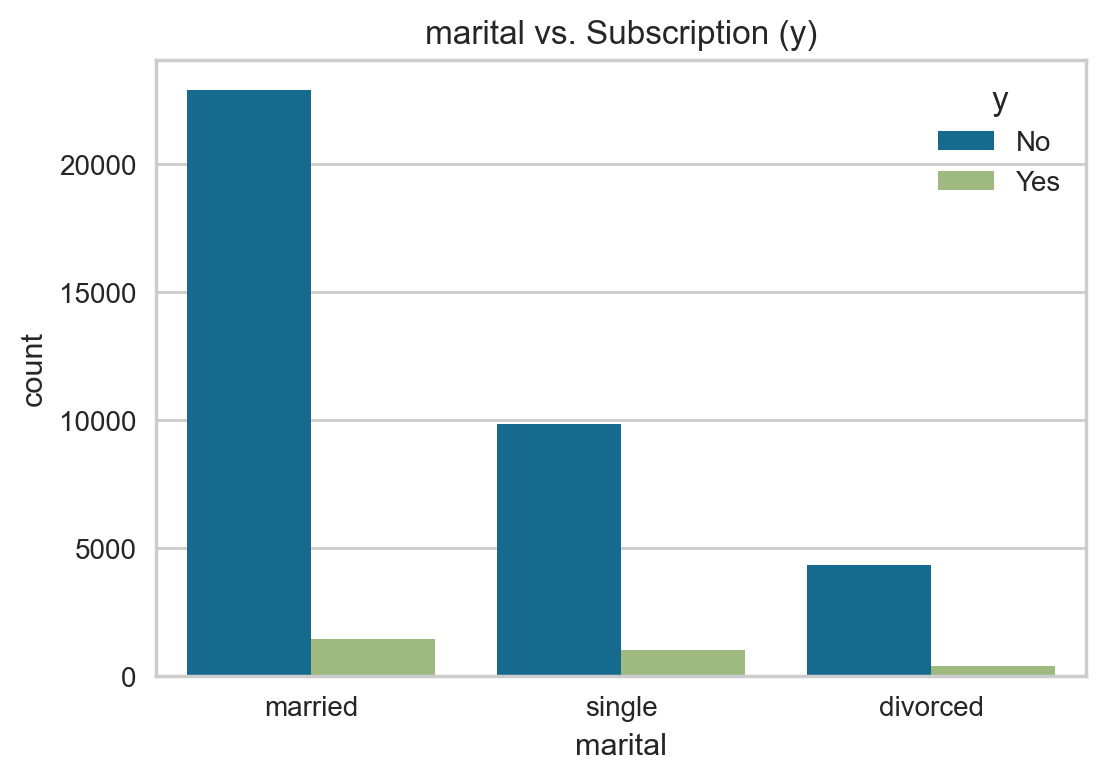

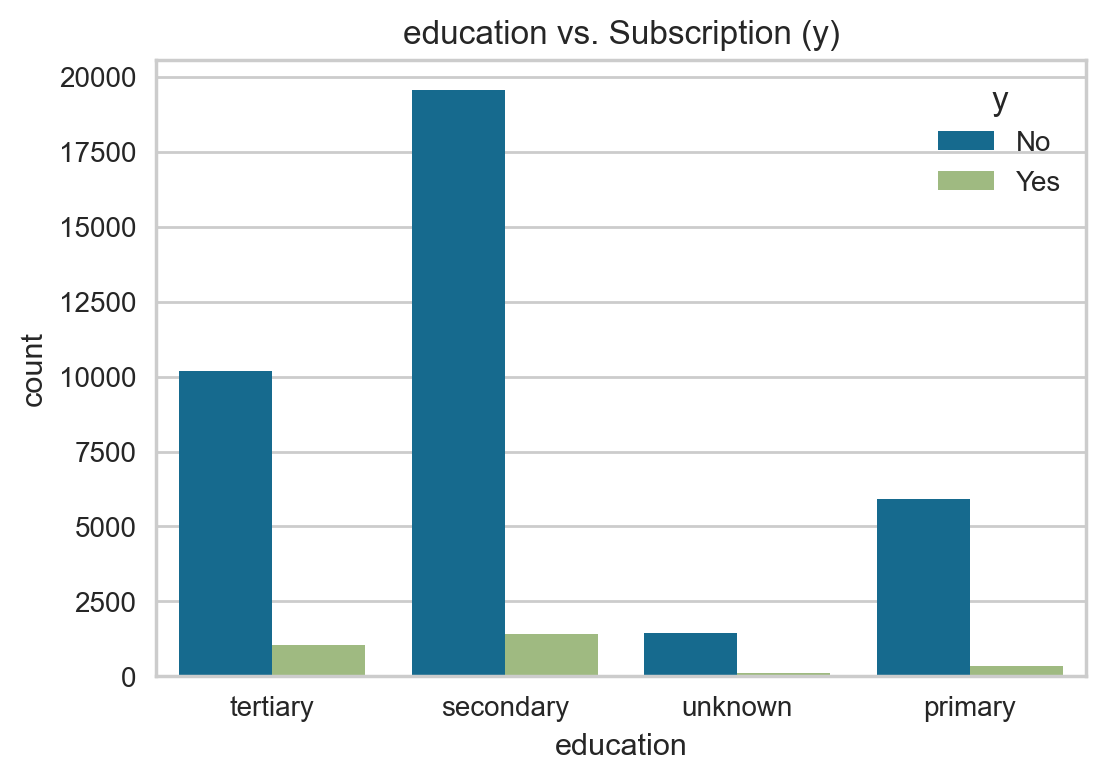

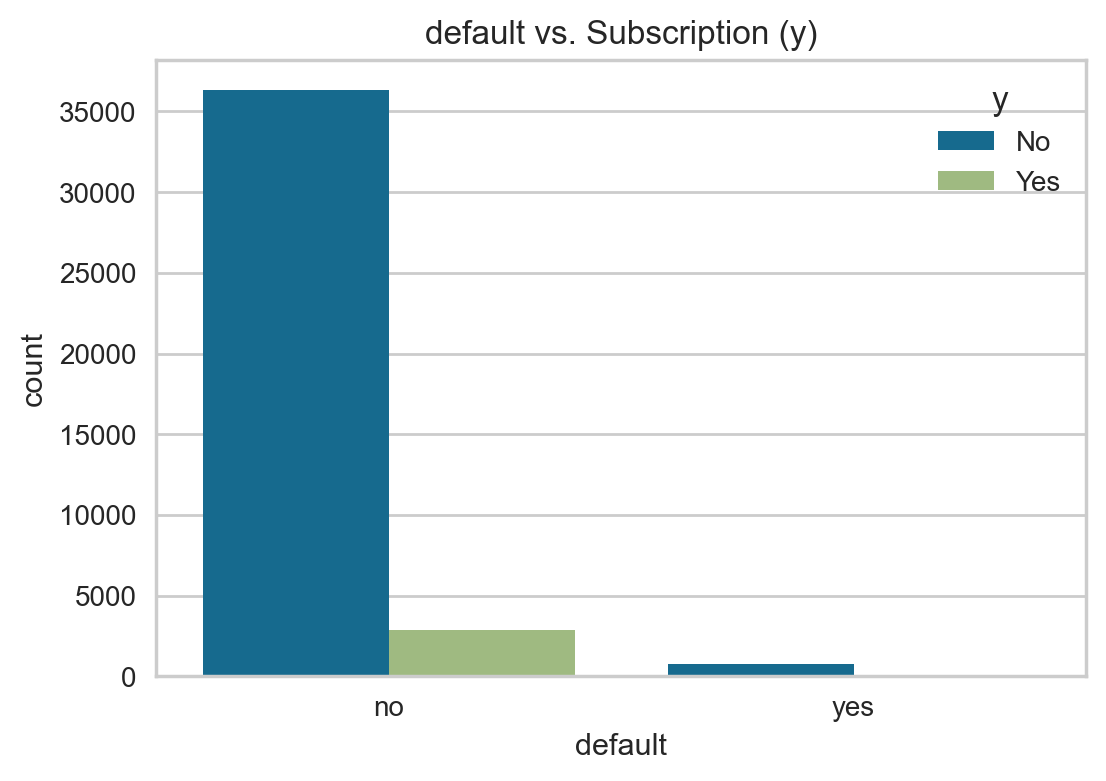

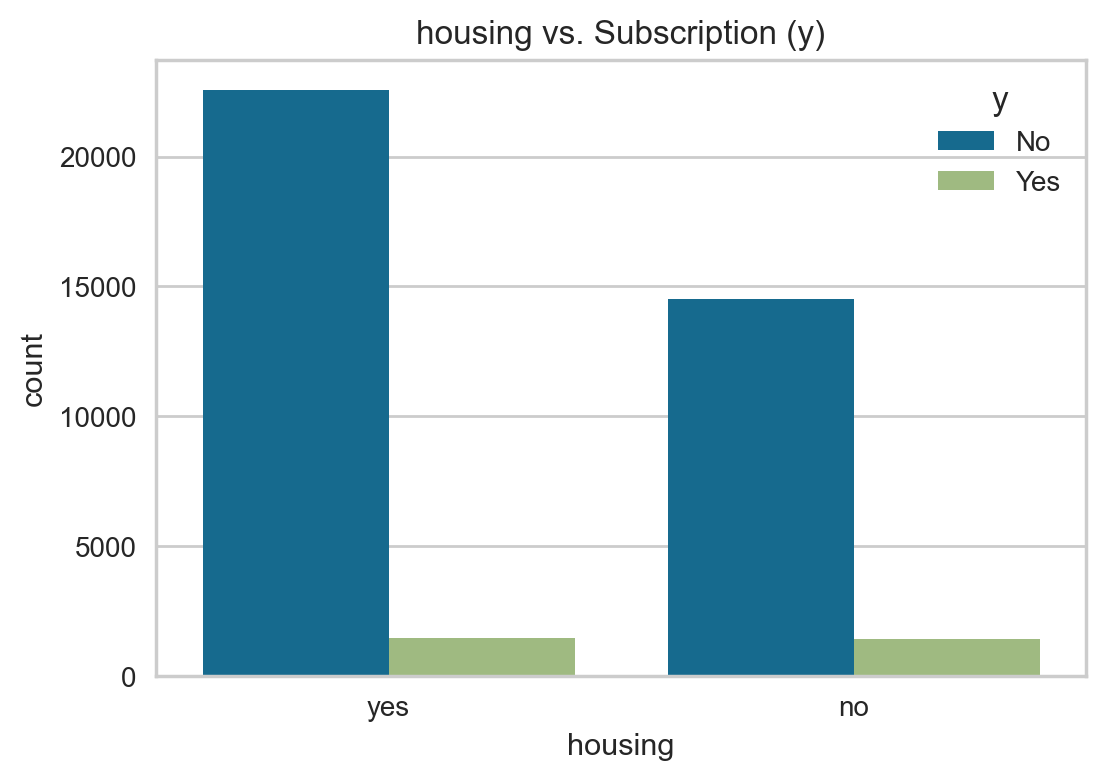

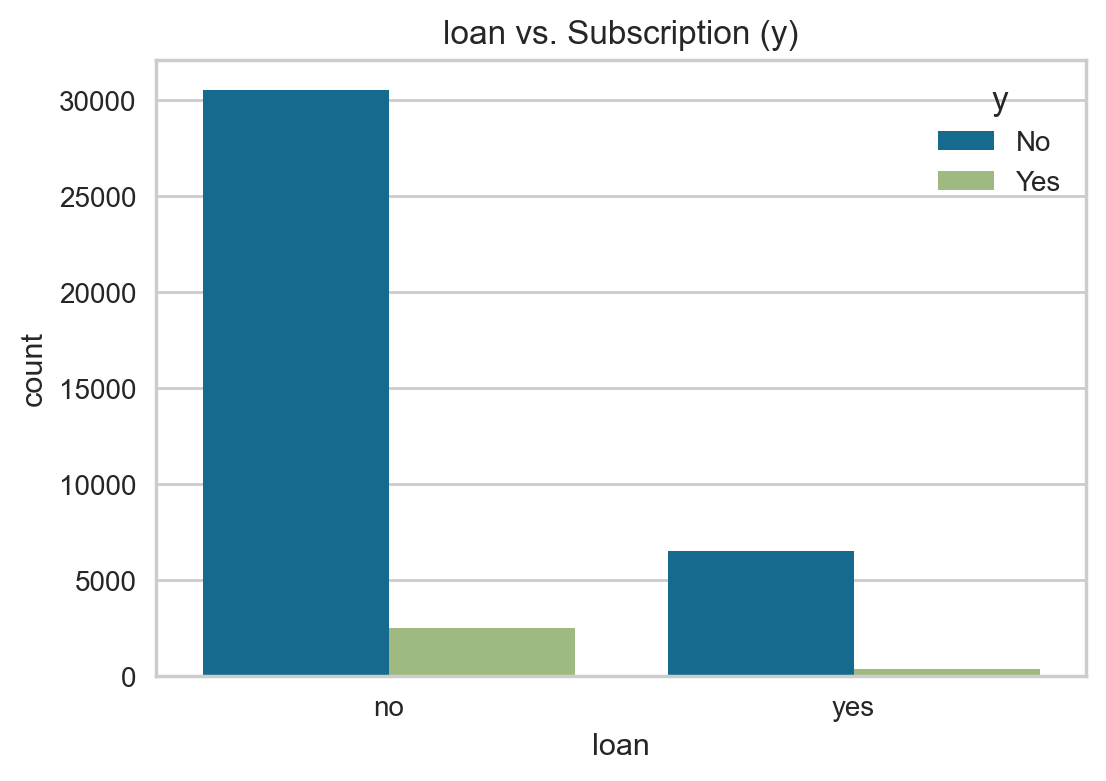

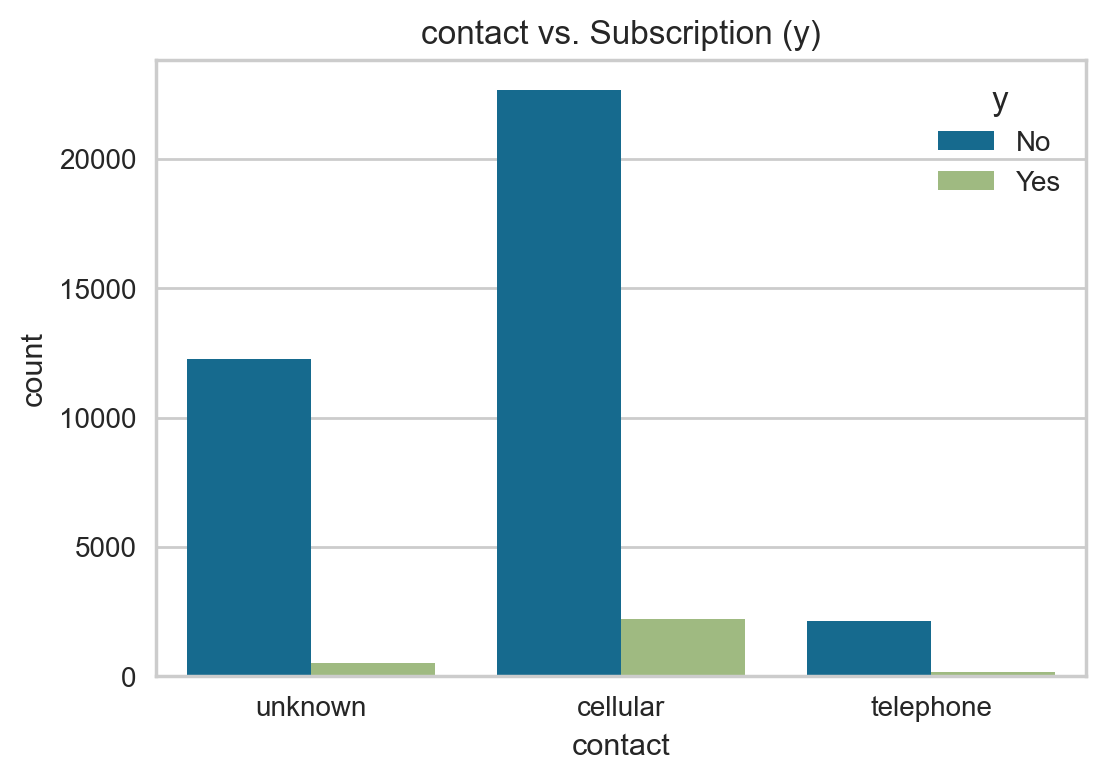

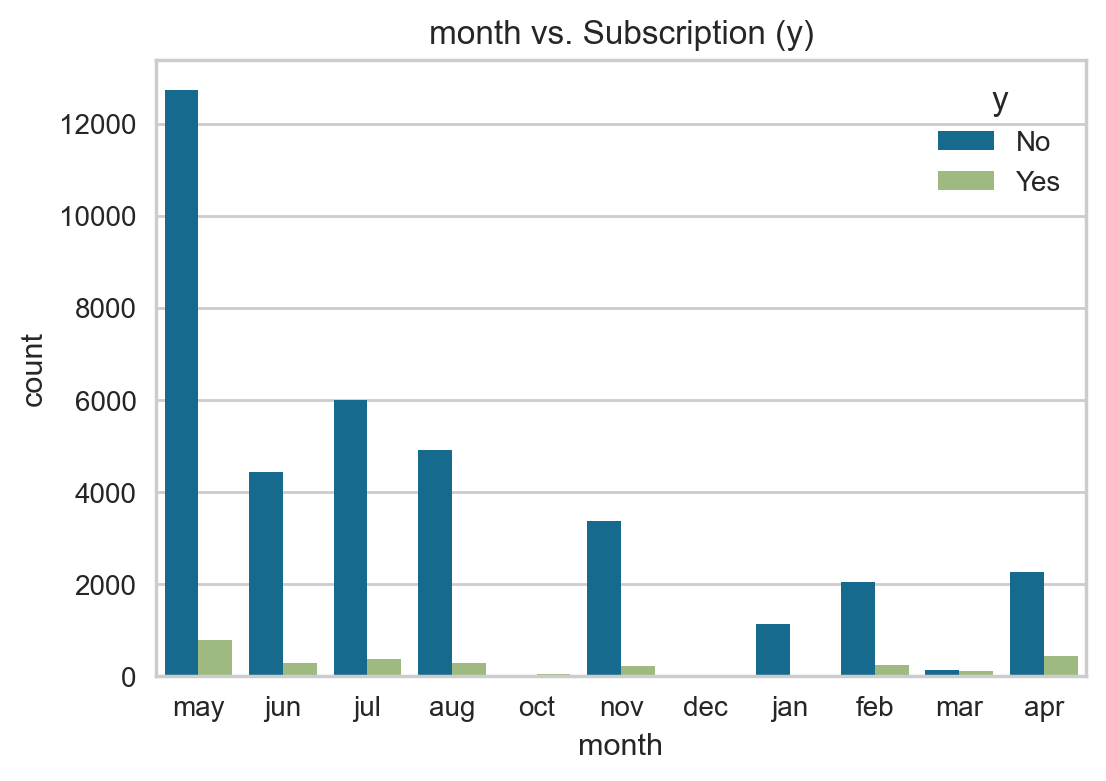

In [102]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='y', data=df)
    plt.title(f"{col} vs. Subscription (y)")
    plt.legend(title='y', labels=['No','Yes'])
    plt.show()

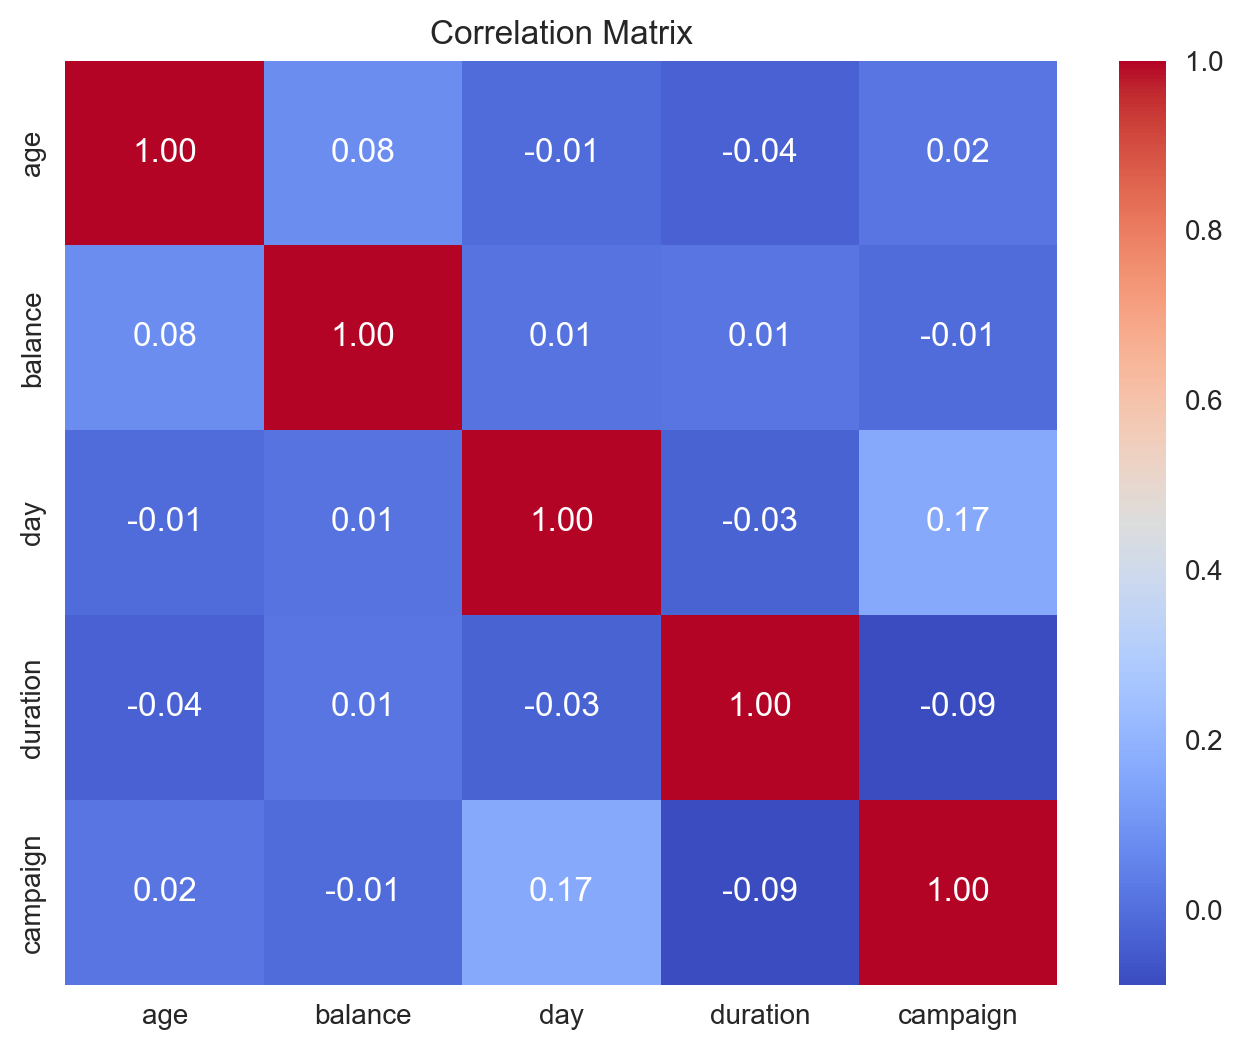

In [103]:
# Only numeric features
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

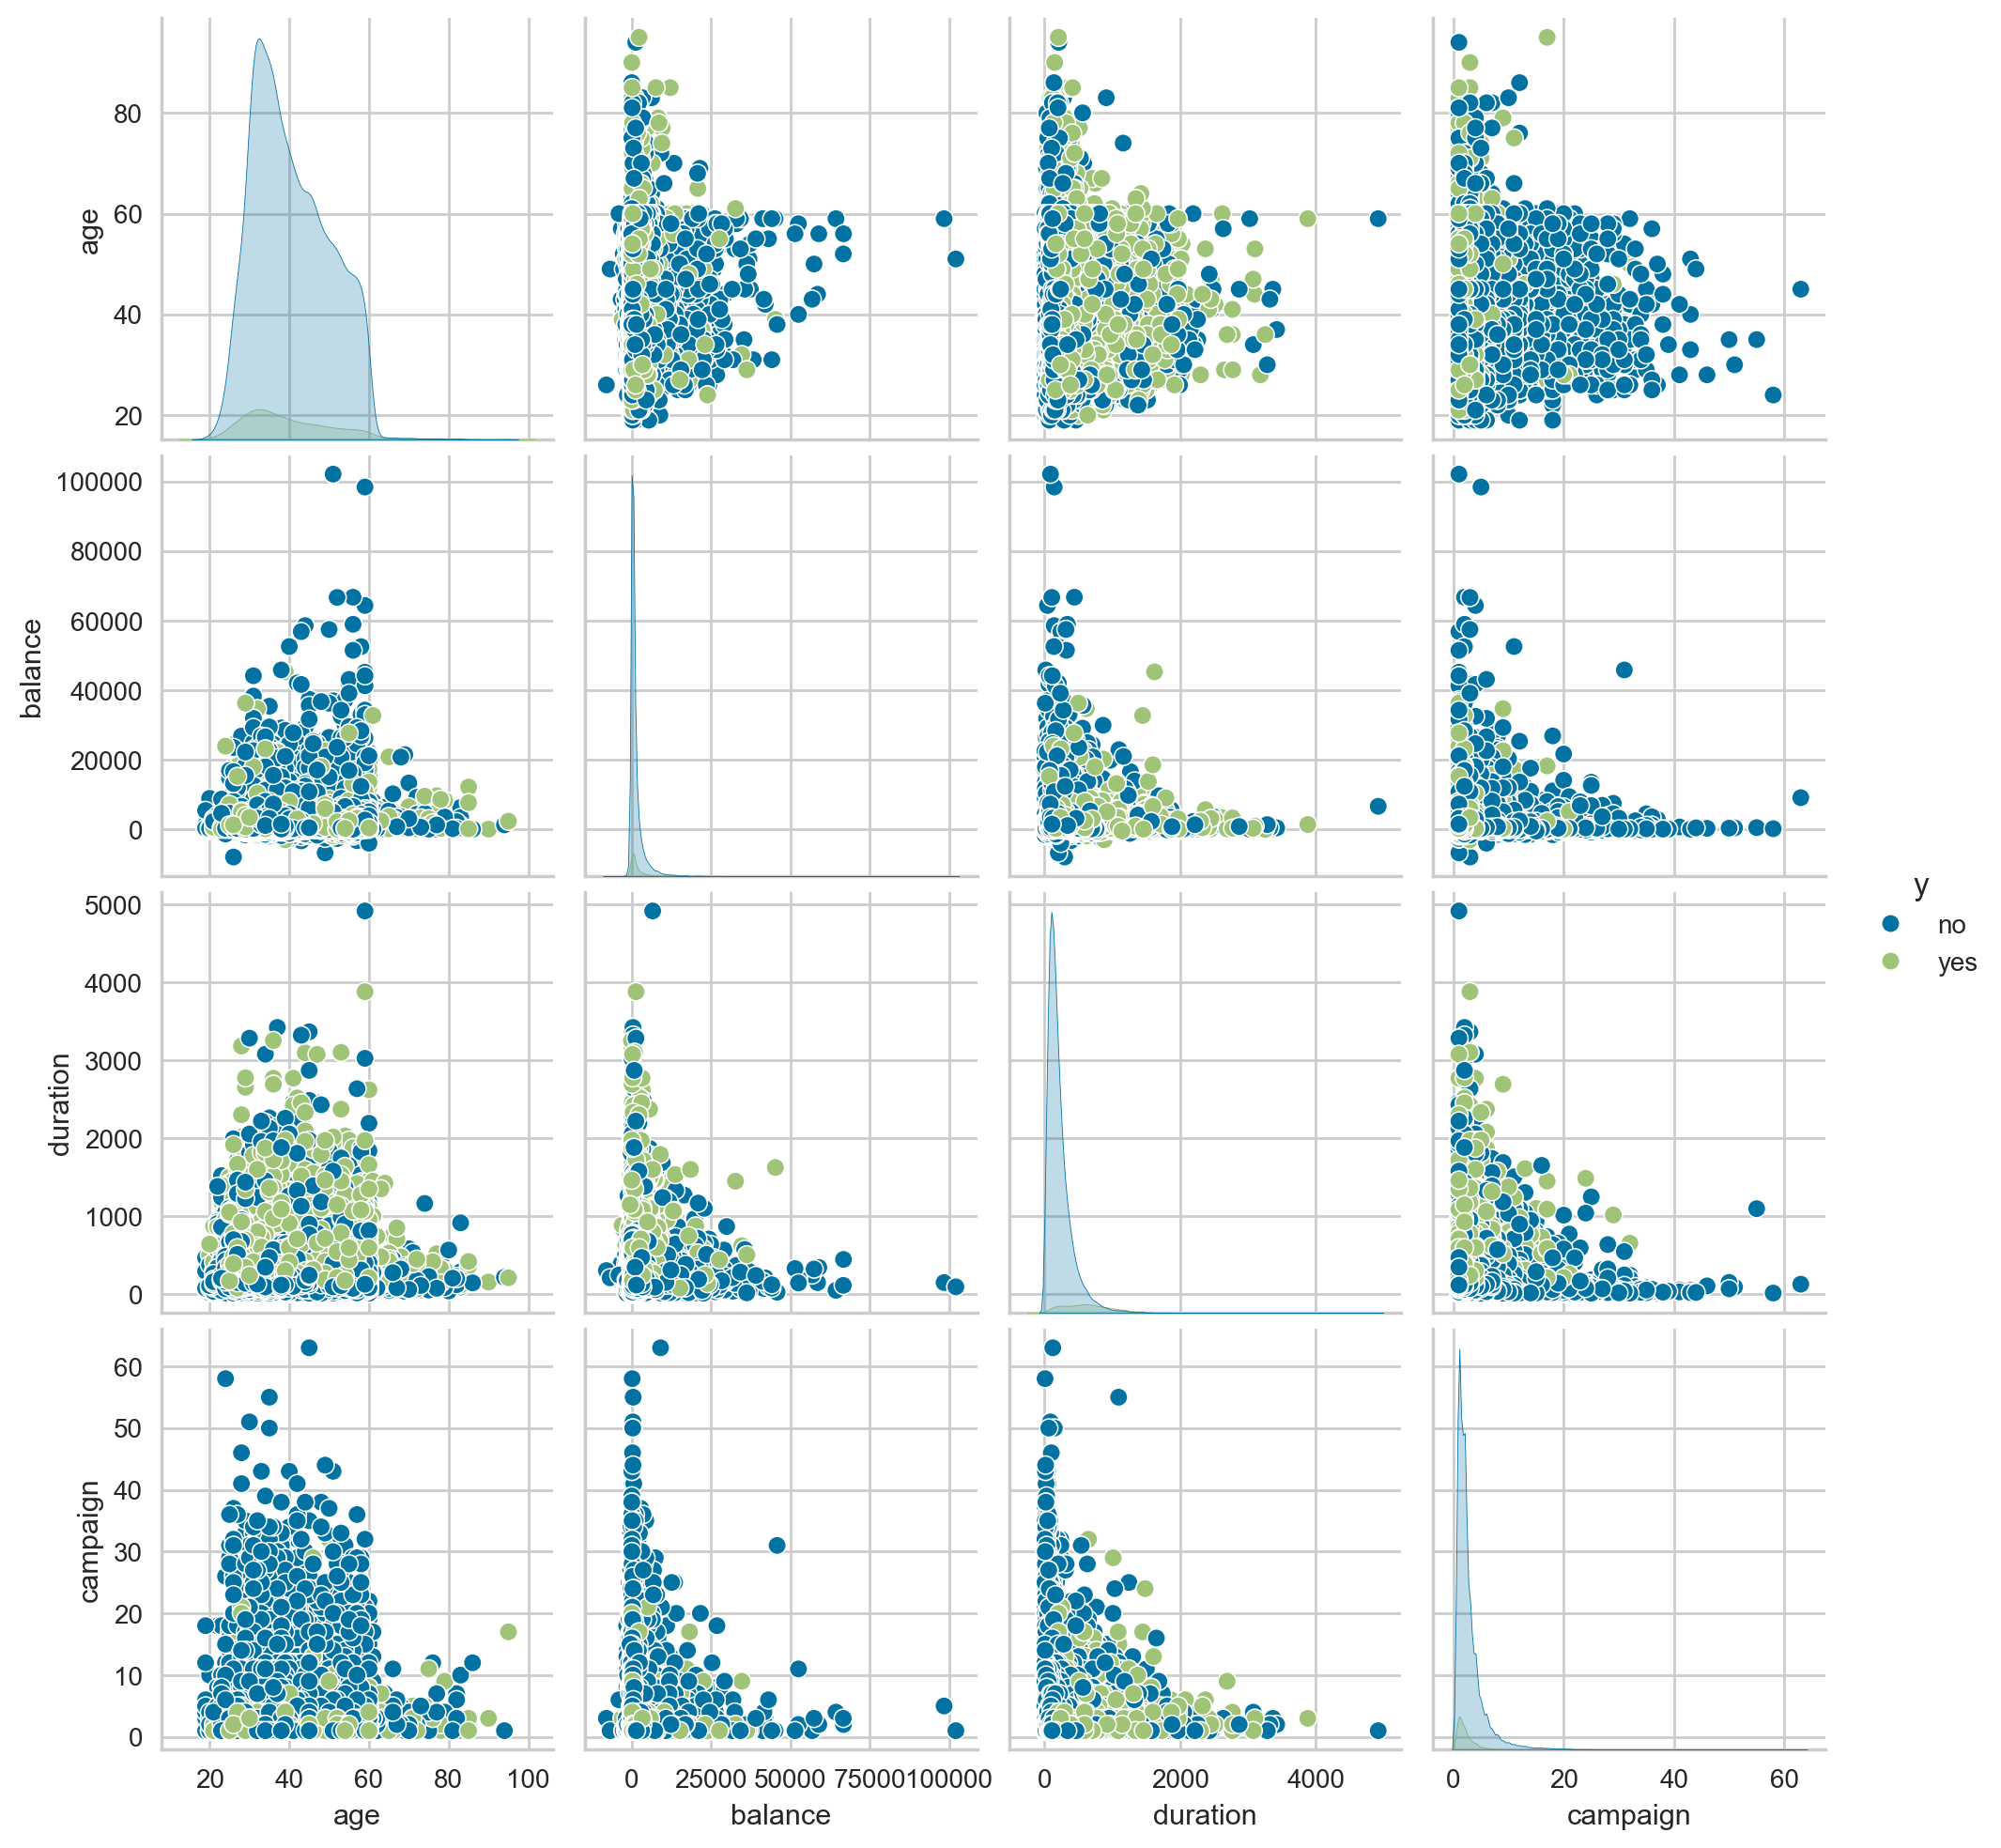

In [105]:
# Pairplot for a small subset of numeric features
sns.pairplot(df, vars=['age','balance','duration','campaign'], hue='y')
plt.show()

# Data Split

In [3]:
#most random seeds produced similar results so went the default 42 for reproducability.
#seed = random.randint(1000, 9999)
seed = 42
print(seed)

42


In [4]:
# Split features and target
X = df.drop('y', axis=1)
y = df['y']

# 75/25 data split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Model selection and preliminary testing

**Key Takeaways:**

1. **LightGBM leads across all major metrics** - highest accuracy (93.91 %), AUC (0.9494), recall (93.91 %), precision (93.16 %), and F1 (93.39 %), while training in ~0.2 s.  
2. **Gradient Boosting (GBM)** is a close second, trading off ~0.10 % in accuracy/AUC for a slightly longer training time.  
3. **Random Forest** offers robust performance (93.65 % accuracy, 0.9392 AUC) with the fastest training among the tree-based methods (0.105 s).

> **Business Impact:**  
> - By deploying **LightGBM**, we can correctly flag 94 % of likely subscribers, minimizing wasted calls and maximizing salesperson productivity.  
> - AUC near 0.95 indicates excellent separation, so thresholds can be tuned (e.g., higher recall for aggressive outreach or higher precision to conserve call resources).  
> - Sub-second training times enable **monthly retraining** with minimal operational overhead.

In [8]:
train_df = X_train
train_df['y'] = y_train

In [9]:
s = setup(train_df, target = 'y', session_id = seed, html=True)

In [10]:
best = compare_models()

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

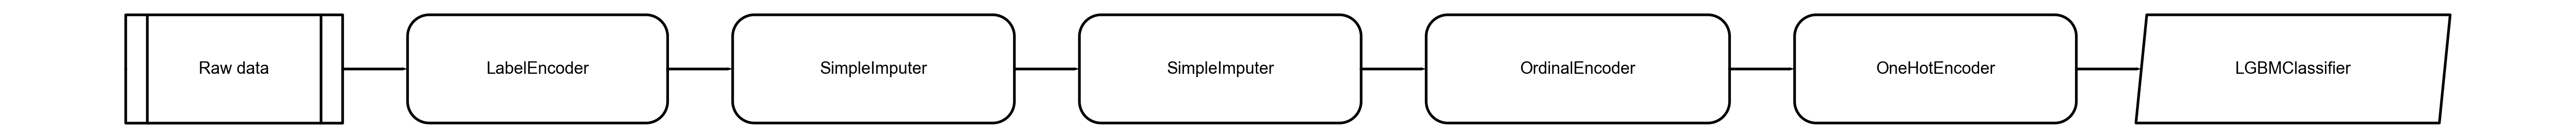

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [12]:
evaluate_model(best)

In [128]:
predict_model(best, verbose = True)

age            job   marital  education default  balance housing loan  \
25698   33  self-employed   married   tertiary      no     -103     yes   no   
29880   37     unemployed   married   tertiary      no      594     yes   no   
23482   45     management   married  secondary      no     2873     yes   no   
15225   40  self-employed   married   tertiary      no     2977     yes   no   
20900   34     technician    single   tertiary      no     2195      no   no   
...    ...            ...       ...        ...     ...      ...     ...  ...   
28621   39     technician  divorced  secondary      no     1333     yes  yes   
26445   44       services   married  secondary      no     -230     yes  yes   
1593    36     technician   married   tertiary      no      491     yes   no   
9391    38    blue-collar   married    primary      no     8251      no   no   
401     48     technician   married  secondary      no      141     yes  yes   

         contact  day month  duration  campaign   y prediction_label  \
25698   cellular   19   nov       149         2  no               no   
29880   cellular    4   feb        62         1  no               no   
23482   cellular   28   aug        30        16  no               no   
15225   cellular   17   jul      1018         1  no              yes   
20900  telephone   13   aug       490         3  no               no   
...          ...  ...   ...       ...       ...  ..              ...   
28621   cellular   29   jan       585         2  no               no   
26445   cellular   20   nov       352         1  no               no   
1593     unknown    8   may       103         3  no               no   
9391     unknown    6   jun       194         3  no               no   
401      unknown    6   may       424         1  no               no   

       prediction_score  
25698            0.9986  
29880            0.9994  
23482            0.9998  
15225            0.5302  
20900            0.7792  
...                 ...  
28621            0.9768  
26445            0.9835  
1593             0.9995  
9391             0.9987  
401              0.9840  

[9000 rows x 16 columns]

In [129]:
test_df = X_val
test_df['y'] = y_val
#test_df.drop('y', axis=1, inplace=True)
test_df.head()

age         job   marital  education default  balance housing loan  \
32823   48  management  divorced   tertiary      no      266     yes   no   
16298   53     retired  divorced  secondary      no       84      no   no   
28505   43  management  divorced   tertiary      no     3578      no   no   
6689    38  technician   married  secondary      no      133     yes   no   
26893   42  management   married   tertiary      no     4014     yes   no   

        contact  day month  duration  campaign   y  
32823  cellular   17   apr       198         2  no  
16298  cellular   23   jul       336         1  no  
28505  cellular   29   jan       376         2  no  
6689    unknown   28   may       156         1  no  
26893  cellular   21   nov       149         4  no

In [130]:
predictions = predict_model(best, data=test_df)
print(predictions)
#predictions.head()

       age         job   marital  education default  balance housing loan  \
32823   48  management  divorced   tertiary      no      266     yes   no   
16298   53     retired  divorced  secondary      no       84      no   no   
28505   43  management  divorced   tertiary      no     3578      no   no   
6689    38  technician   married  secondary      no      133     yes   no   
26893   42  management   married   tertiary      no     4014     yes   no   
...    ...         ...       ...        ...     ...      ...     ...  ...   
29415   33    services   married  secondary      no      312     yes  yes   
11359   44       admin    single  secondary      no     2524      no   no   
575     61     retired   married  secondary      no      195     yes  yes   
17398   26    services    single  secondary      no     1163      no  yes   
4189    38  management    single   tertiary      no      889      no   no   

        contact  day month  duration  campaign   y prediction_label  \
3282

In [131]:
lightgbm = create_model('lightgbm')

In [ ]:
#No improvements in the tuned LGBM model

In [132]:
tuned_lightgbm = tune_model(lightgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Feature Selection

- **Approach:** leveraged PyCaret’s built-in feature selection by enabling `feature_selection=True` and specifying `RandomForestClassifier(n_estimators=100)` as the selection estimator. This performs recursive elimination to drop low-importance variables.

- **Selected Features:**  
  Out of the original 13 attributes, the algorithm distilled the model down to **five key predictors**:  
  1. `age`  
  2. `balance`  
  3. `day` (day of month of last contact)  
  4. `duration` (last call duration)  
  5. `campaign` (number of calls in current campaign)  

- **Retrained Model:**  
  Re-ran model comparison and hyperparameter tuning on this reduced dataset. The best performer (LightGBM) retained virtually the same classification performance (F1-score on the "yes" class) as the full-feature model, demonstrating that these five features capture nearly all of the predictive signal.

- **Business Impact:**  
  - **Operational Efficiency:** Focusing on five variables simplifies data ingestion and model maintenance (fewer joins, less preprocessing).  
  - **Stakeholder Trust:** A concise feature set makes it easier to explain and justify predictions to compliance and marketing teams.  
  - **Targeted Strategy:** The retained features map directly to actionable levers—demographics (`age`, `balance`) and call tactics (`day`, `duration`, `campaign` count), so teams can optimize call scheduling, invest in longer dialogues, and limit repeat dials beyond the point of diminishing returns.


In [133]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
s2 = setup(train_df, target = 'y', session_id = seed, feature_selection=True, feature_selection_estimator=RandomForestClassifier(n_estimators=100), 
           n_features_to_select=5)

In [135]:
best1 = compare_models()

In [136]:
print(get_config()) 

{'_ml_usecase', 'y_transformed', 'fold_groups_param', 'n_jobs_param', 'is_multiclass', 'fix_imbalance', 'X_transformed', 'pipeline', 'data', 'dataset_transformed', 'html_param', 'idx', 'test', 'gpu_n_jobs_param', 'exp_id', '_available_plots', 'fold_shuffle_param', 'train_transformed', 'USI', 'dataset', 'X', 'target_param', 'train', 'test_transformed', 'variables', 'fold_generator', 'X_train', 'X_test_transformed', 'y_test', 'variable_and_property_keys', 'memory', 'y_test_transformed', 'exp_name_log', 'X_train_transformed', 'X_test', 'gpu_param', 'seed', 'logging_param', 'y_train', 'y', 'y_train_transformed', 'log_plots_param'}


In [137]:
X_train_selected = get_config('X_train_transformed')

In [138]:
print("Selected features:")
for feat in X_train_selected.columns:
    print(" •", feat)

Selected features:
 • age
 • balance
 • day
 • duration
 • campaign


In [143]:
train_df_reduced = get_config('X_train_transformed')
train_df_reduced['y'] = get_config('y_train_transformed')

In [144]:
s = setup(train_df_reduced, target = 'y', session_id = seed, html=True)

In [145]:
best2 = compare_models()

In [163]:
predictions = predict_model(best2)

In [164]:
train_df_reduced.head()

age  balance   day  duration  campaign  y
30619  44.0    196.0   6.0     386.0       3.0  0
17378  38.0   -275.0  28.0     165.0       3.0  0
124    52.0      7.0   5.0     175.0       1.0  0
4659   32.0    908.0  20.0      64.0       1.0  0
9456   35.0      0.0   6.0     159.0       3.0  0

In [166]:
test_df_reduced = get_config('X_test_transformed')  #test_df[['age','balance','day','duration','campaign','y']]
test_df_reduced['y'] = get_config('y_test_transformed')

In [167]:
test_df_reduced.head()

age  balance   day  duration  campaign  y
2018   48.0    296.0   9.0     164.0       8.0  0
13763  31.0     12.0  10.0      81.0       3.0  0
38596  28.0    118.0  15.0     376.0       3.0  0
32178  44.0   4581.0  15.0     520.0       3.0  0
14491  27.0      0.0  14.0     227.0       4.0  0

In [168]:
predict_model(best2, data=test_df_reduced)

age  balance   day  duration  campaign  y  prediction_label  \
2018   48.0    296.0   9.0     164.0       8.0  0                 0   
13763  31.0     12.0  10.0      81.0       3.0  0                 0   
38596  28.0    118.0  15.0     376.0       3.0  0                 0   
32178  44.0   4581.0  15.0     520.0       3.0  0                 0   
14491  27.0      0.0  14.0     227.0       4.0  0                 0   
...     ...      ...   ...       ...       ... ..               ...   
13996  39.0    397.0  10.0     113.0       6.0  0                 0   
7000   35.0     51.0  28.0     593.0       2.0  0                 0   
22219  50.0      0.0  21.0     120.0       2.0  0                 0   
10336  45.0    221.0  12.0      93.0       1.0  0                 0   
11555  55.0      0.0  19.0     120.0       1.0  0                 0   

       prediction_score  
2018             0.9884  
13763            0.9914  
38596            0.9177  
32178            0.7559  
14491            0.9724  
...                 ...  
13996            0.9885  
7000             0.8725  
22219            0.9896  
10336            0.9873  
11555            0.9864  

[4410 rows x 8 columns]

In [169]:
qda = create_model('qda')

In [170]:
predict_model(qda, data=test_df_reduced)

age  balance   day  duration  campaign  y  prediction_label  \
2018   48.0    296.0   9.0     164.0       8.0  0                 0   
13763  31.0     12.0  10.0      81.0       3.0  0                 0   
38596  28.0    118.0  15.0     376.0       3.0  0                 0   
32178  44.0   4581.0  15.0     520.0       3.0  0                 0   
14491  27.0      0.0  14.0     227.0       4.0  0                 0   
...     ...      ...   ...       ...       ... ..               ...   
13996  39.0    397.0  10.0     113.0       6.0  0                 0   
7000   35.0     51.0  28.0     593.0       2.0  0                 0   
22219  50.0      0.0  21.0     120.0       2.0  0                 0   
10336  45.0    221.0  12.0      93.0       1.0  0                 0   
11555  55.0      0.0  19.0     120.0       1.0  0                 0   

       prediction_score  
2018             0.9991  
13763            0.9755  
38596            0.9383  
32178            0.8582  
14491            0.9732  
...                 ...  
13996            0.9953  
7000             0.7145  
22219            0.9785  
10336            0.9801  
11555            0.9780  

[4410 rows x 8 columns]

# SQL for isolating Subscribers

In [171]:
pip install duckdb

   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.4 MB 13.8 MB/s eta 0:00:01
   ---------------- ----------------------- 4.7/11.4 MB 12.4 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.4 MB 12.8 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.4 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 12.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [172]:
import duckdb

conn = duckdb.connect(database='term_deposit.duckdb', read_only=False)

In [175]:
conn.execute(f"""
CREATE TABLE term_deposit AS
SELECT *
FROM read_csv_auto('{path}');
""")

In [177]:
# Show the first 5 rows
print(conn.execute("SELECT * FROM term_deposit LIMIT 5;").fetchdf())

# Check row count
print("Total rows:", conn.execute("SELECT COUNT(*) FROM term_deposit;").fetchone()[0])

   age           job  marital  education  default  balance  housing   loan  \
0   58    management  married   tertiary    False     2143     True  False   
1   44    technician   single  secondary    False       29     True  False   
2   33  entrepreneur  married  secondary    False        2     True   True   
3   47   blue-collar  married    unknown    False     1506     True  False   
4   33       unknown   single    unknown    False        1    False  False   

   contact  day month  duration  campaign      y  
0  unknown    5   may       261         1  False  
1  unknown    5   may       151         1  False  
2  unknown    5   may        76         1  False  
3  unknown    5   may        92         1  False  
4  unknown    5   may       198         1  False  
Total rows: 40000


In [178]:
# Create subscribers table
conn.execute("""
CREATE TABLE subscribers AS
SELECT *
FROM term_deposit
WHERE y = 'yes';
""")

In [180]:
count_sub = conn.execute("SELECT COUNT(*) FROM subscribers;").fetchone()[0]
print(f"Subscribers:      {count_sub}")

Subscribers:      2896


In [182]:
# Export as CSV
conn.execute("""
COPY subscribers
TO 'C:/Users/dbal/anaconda_projects/TermDeposit/subscribers_only.csv'
WITH (HEADER, DELIMITER ',');
""")

# K-means Clustering

Objective: Identify natural subgroups among those who subscribed, so marketing can craft cluster-specific scripts and offers.

In [5]:
df_subs = pd.read_csv('/TermDeposit/subscribers_only.csv')
df_subs.head()

age         job  marital  education  default  balance  housing   loan  \
0   59       admin  married  secondary    False     2343     True  False   
1   56       admin  married  secondary    False       45    False  False   
2   41  technician  married  secondary    False     1270     True  False   
3   55    services  married  secondary    False     2476     True  False   
4   54       admin  married   tertiary    False      184    False  False   

   contact  day month  duration  campaign     y  
0  unknown    5   may      1042         1  True  
1  unknown    5   may      1467         1  True  
2  unknown    5   may      1389         1  True  
3  unknown    5   may       579         1  True  
4  unknown    5   may       673         2  True

In [17]:
subs_encoded = pd.get_dummies(df_subs, columns=cat_cols, drop_first=True)
subs_encoded.head()

age  balance  day  duration  campaign     y  job_blue-collar  \
0   59     2343    5      1042         1  True                0   
1   56       45    5      1467         1  True                0   
2   41     1270    5      1389         1  True                0   
3   55     2476    5       579         1  True                0   
4   54      184    5       673         2  True                0   

   job_entrepreneur  job_housemaid  job_management  ...  month_aug  month_dec  \
0                 0              0               0  ...          0          0   
1                 0              0               0  ...          0          0   
2                 0              0               0  ...          0          0   
3                 0              0               0  ...          0          0   
4                 0              0               0  ...          0          0   

   month_feb  month_jan  month_jul  month_jun  month_mar  month_may  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          0          0          0          0          1   

   month_nov  month_oct  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 37 columns]

In [18]:
X = subs_encoded.drop(columns=['y', 'y_encoded'], errors='ignore', axis=1)
X.head()

age  balance  day  duration  campaign  job_blue-collar  job_entrepreneur  \
0   59     2343    5      1042         1                0                 0   
1   56       45    5      1467         1                0                 0   
2   41     1270    5      1389         1                0                 0   
3   55     2476    5       579         1                0                 0   
4   54      184    5       673         2                0                 0   

   job_housemaid  job_management  job_retired  ...  month_aug  month_dec  \
0              0               0            0  ...          0          0   
1              0               0            0  ...          0          0   
2              0               0            0  ...          0          0   
3              0               0            0  ...          0          0   
4              0               0            0  ...          0          0   

   month_feb  month_jan  month_jul  month_jun  month_mar  month_may  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          0          0          0          0          1   

   month_nov  month_oct  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 36 columns]

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

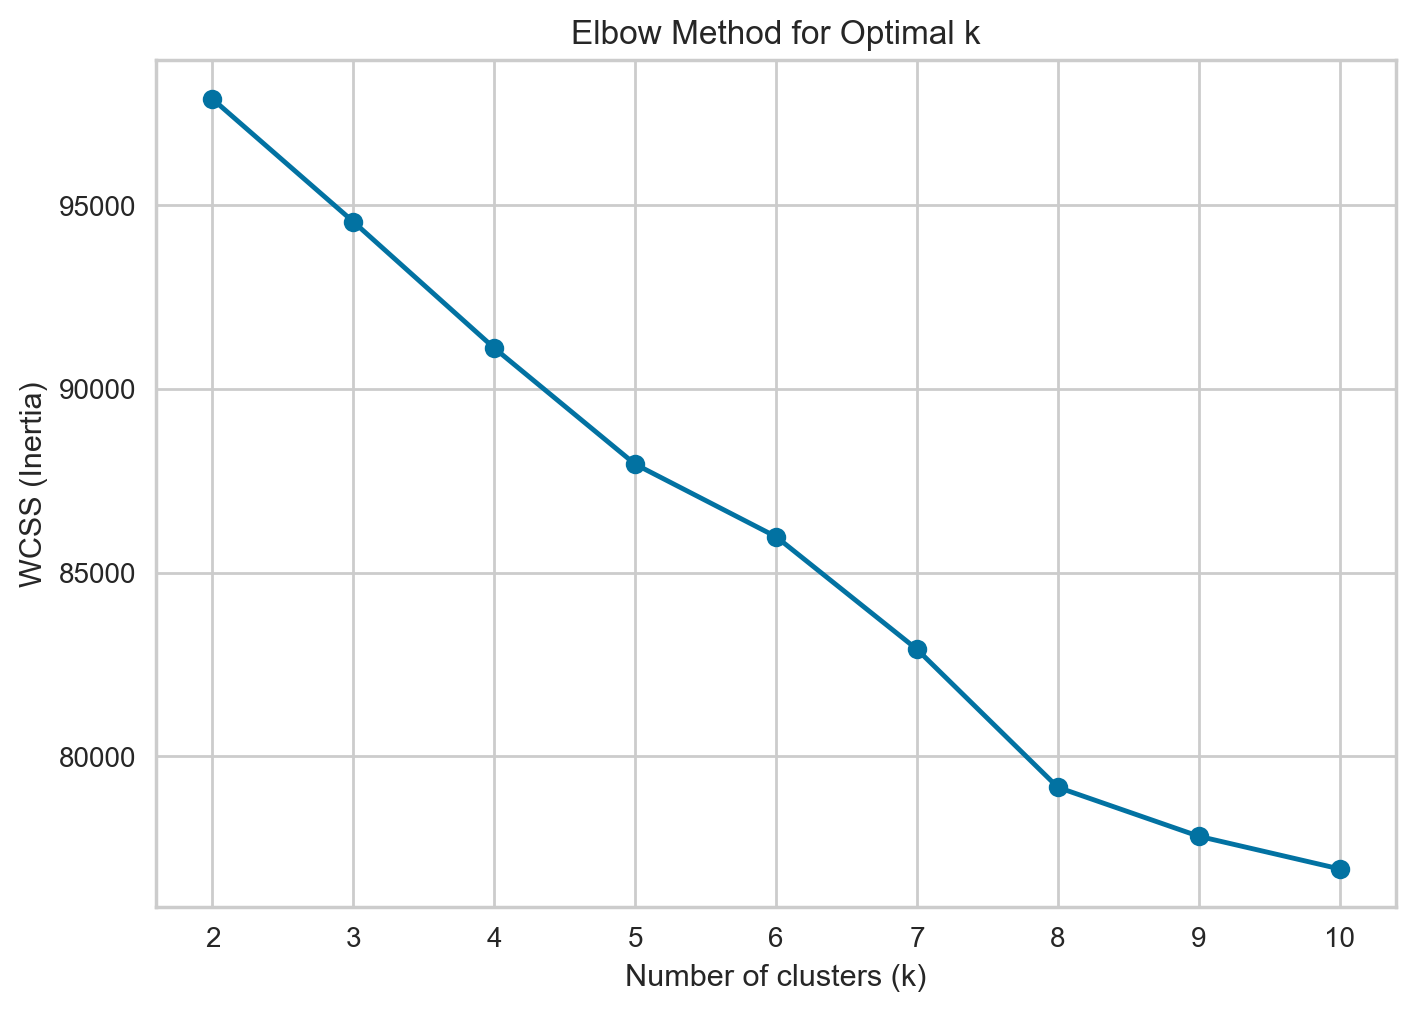

In [20]:
wcss = []
K_range = range(2, 11)  # try k from 2 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

plt.plot(K_range, wcss, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

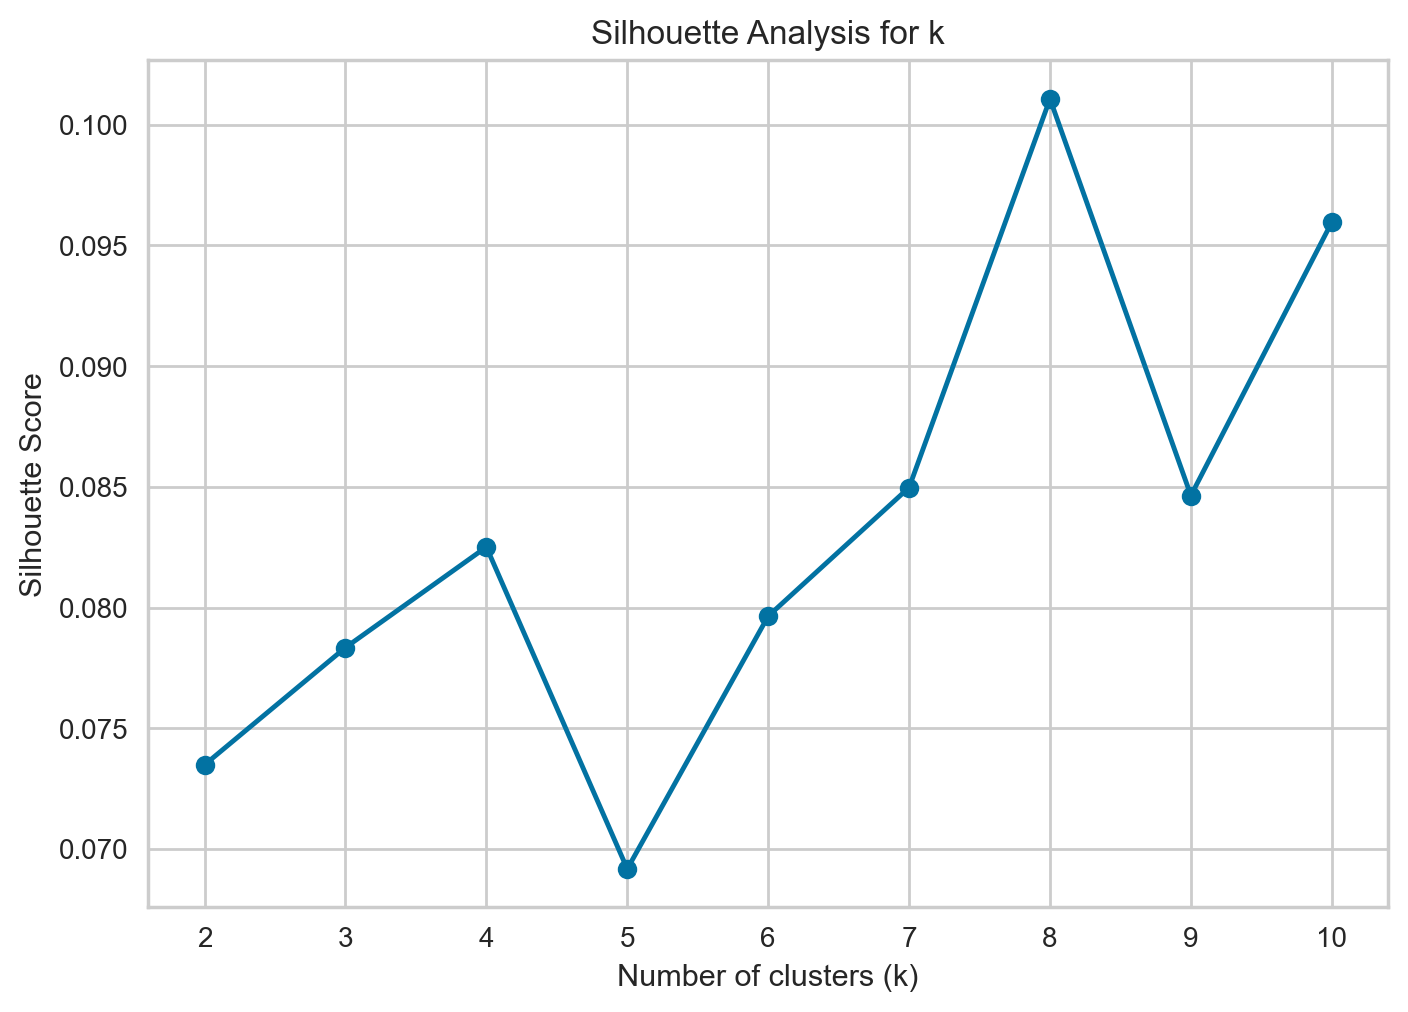

In [23]:
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.plot(K_range, sil_scores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for k')
plt.show()

After testing with few different values for K, k=4 has a better group distinction. Even though k=8 has a higher silhouette score, class distinction is poor compared to K=4.

In [25]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=seed)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the subscribers DataFrame
df_subs['cluster'] = cluster_labels

In [29]:
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original, columns=X.columns)
print(centroids_df)

         age      balance        day    duration  campaign  job_blue-collar  \
0  39.564450  1927.483039  15.671642  609.050204  2.507463     5.551115e-17   
1  34.986979  1650.364583  16.686198  613.571615  2.205729     2.994792e-02   
2  62.632258  2518.187097  16.909677  567.232258  2.264516     0.000000e+00   
3  40.173139  1231.334951  15.250000  784.655340  2.507282     4.142395e-01   

   job_entrepreneur  job_housemaid  job_management   job_retired  ...  \
0          0.047490       0.009498    8.575305e-01 -7.632783e-17  ...   
1          0.007812       0.001302    1.432292e-02 -8.326673e-17  ...   
2          0.000000       0.000000   -5.551115e-17  9.741935e-01  ...   
3          0.038026       0.036408    2.669903e-02 -1.249001e-16  ...   

   month_aug     month_dec  month_feb  month_jan  month_jul  month_jun  \
0   0.158752  1.356852e-03   0.103121   0.001357   0.094980   0.090909   
1   0.125000 -1.626303e-19   0.135417   0.041667   0.085937   0.054688   
2   0.109677  5.

In [30]:
cluster_counts = df_subs['cluster'].value_counts().sort_index()
print("Subscribers per cluster:")
print(cluster_counts)

Subscribers per cluster:
0     737
1     768
2     155
3    1236
Name: cluster, dtype: int64


In [31]:
print(df_subs.groupby('cluster')[num_cols].mean())
print(df_subs.groupby('cluster')['job'].agg(lambda x: x.value_counts().idxmax()))
print(df_subs.groupby('cluster')['month'].agg(lambda x: x.value_counts().idxmax()))

               age      balance        day    duration  campaign
cluster                                                         
0        39.564450  1927.483039  15.671642  609.050204  2.507463
1        34.986979  1650.364583  16.686198  613.571615  2.205729
2        62.632258  2518.187097  16.909677  567.232258  2.264516
3        40.173139  1231.334951  15.250000  784.655340  2.507282
cluster
0     management
1     technician
2        retired
3    blue-collar
Name: job, dtype: object
cluster
0    may
1    may
2    apr
3    may
Name: month, dtype: object


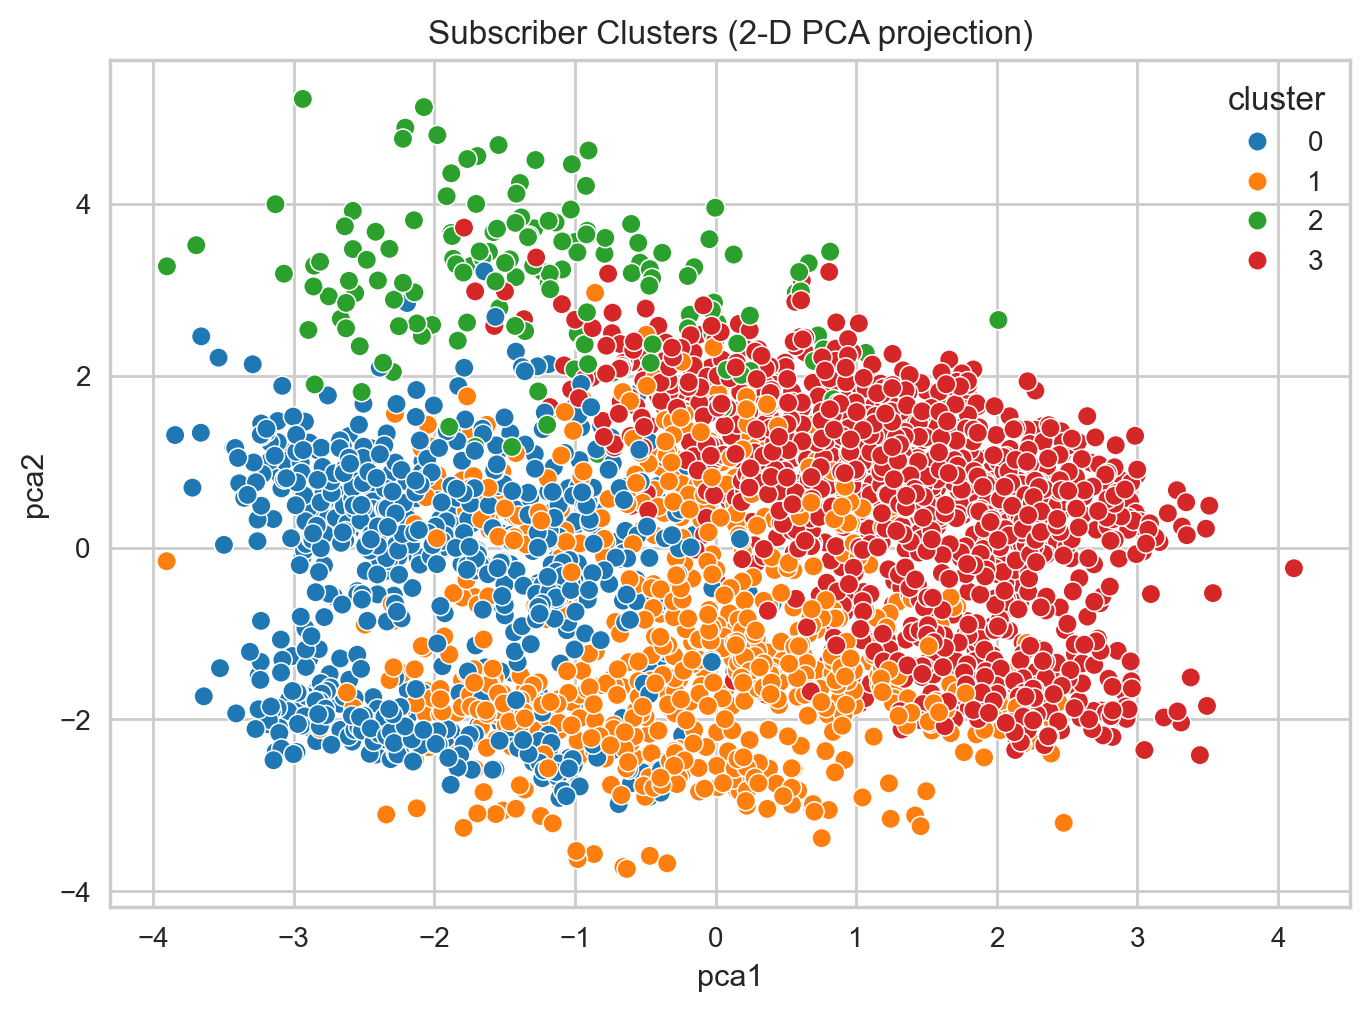

In [34]:
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X_scaled)
df_subs['pca1'] = X_pca[:, 0]
df_subs['pca2'] = X_pca[:, 1]

sns.scatterplot(data=df_subs, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title('Subscriber Clusters (2-D PCA projection)')
plt.show()

Below are the average profiles for each cluster (age, balance, call duration, etc.):

| Cluster | Avg Age | Avg Balance | Avg Duration | Dominant Job     |
|---------|--------:|------------:|-------------:|------------------|
| 0       |  39.56  |  €1927.48   |  10.15 min   | management       |
| 1       |  34.99  |  €1650.36   |  10.23 min   | technician       |
| 2       |  62.63  |  €2518.18   |  9.45 min    | retired          |
| 3       |  40.17  |  €1231.33   |  13.08 min   | blue-collar      |

---
## Cluster 0:

**Profile**  
- **Age:** ~40 years  
- **Balance:** ~€1.9 k  
- **Call Length:** ~10 min  

**Why They Subscribe**  
Likely receptive to retirement-oriented savings pitches and mid-term investment plans.

**Potential Action Items**  
- Emphasize **growth potential** and **tiered loyalty benefits**.


## Cluster 1:

**Profile**  
- **Age:** ~35 years  
- **Balance:** ~€1.65 k  
- **Call Length:** ~10.2 min  

**Why They Subscribe**  
May value practical, straightforward deposit products with flexible withdrawal.

**Potential Action Items**  
- Pitch **short-duration term options** (e.g., 3–6 months).  
- Highlight **mobile-app management** features for ease of access.


## Cluster 2:

**Profile**  
- **Age:** ~63 years  
- **Balance:** ~€2.5 k  
- **Call Length:** ~9.5 min  

**Why They Subscribe**  
Likely looking for safe, stable returns and peace of mind as a complement to retirement income.

**Potential Action Items**  
- Lead with **guaranteed-interest rates** and **capital preservation** messaging.  
- Offer **longer-term deposits** (1–2 years) with incremental rate bumps for loyalty.


## Cluster 3:

**Profile**  
- **Age:** ~40 years  
- **Balance:** ~€1.2 k  
- **Call Length:** ~13.1 min _(longest of all clusters)_

**Why They Subscribe**  
Despite lower balances, they engage in the **longest conversations**, indicating openness when given time.


**Potential Action Items**  
- Train agents to **build rapport and trust.** This group responds when you listen and explain patiently.  
- Introduce **low-entry offers** with **step-up incentives** for repeat deposits.

---

## Summary

- **Cluster 2 (Retirees):** Highest average balance,**push premium, long-term products**.  
- **Cluster 3 (Blue-Collar):** High engagement despite lower balances,**nurture relationships** to grow lifetime value.  
- **Clusters 0 & 1:** Largest segments,**tailor mid-tier, flexible offerings** to capture additional share.